# Introduction

### About 
This Jupyter Notebook is the official submission of Joel Amarou Heuer (matriculation number: 5190050) for the seminar "S: Cybersecurity & AI: AI/ML Attacks" in the summer term 2023 at Freie Universität Berlin taught by Prof. Dr.-Ing. Gerhard Wunder, Hamed H. Fard and Daniel Becker.

The objective of this project is to implement the methodology of the paper "Variational Autoencoder based Anomaly Detection using Reconstruction Probability" (2015) by Jinwon An, Sungzoon Cho and at best to reproduce the results presented in the paper.

Link to paper: http://dm.snu.ac.kr/static/docs/TR/SNUDM-TR-2015-03.pdf

### Flaws of Paper
While implementing, problems occurred with the probabilistic variational autoencoder (pVAE) due to the inconsistent method description in the paper. Models learned poorly and, accordingly, could not produce good reconstructions. Finally, under these circumstances, Anomaly Detection also failed.

Although the paper is often cited, it is not free of inaccuracies. For example, the definition of "Reconstruction Probability" is not correctly described, and mathematical nuances are ignored. 

After some research, it turned out that other people also had problems with the method and criticized the paper. Here are a few examples:

1. **Definition Reconstruction Probability**: The authors present two definitions for "Reconstruction Probability". On page 8, they defined it as the expectation of the log-likelihood under the latent variable. On page 9, they estimated the expectation of the probability. During their experiments, they switch back and forth between both definitions and are therefore inconsistent.

2. **Sigma always 1**: The authors assume that sigma is always 1 to avoid the challenge of learning sigma. Following this assumption, Mean Squared Error (MSE) is basically used again.

Sources:
-  [StackExchange - Obtaining VAE Reconstruction Probability](https://stats.stackexchange.com/questions/427597/obtaining-vae-reconstruction-probability)
-  [James D. McCaffrey - Anomaly Detection Using VAE Reconstruction Probability](https://jamesmccaffrey.wordpress.com/2021/03/11/anomaly-detection-using-variational-autoencoder-reconstruction-probability/)

### Experiments 
This notebook tests two model architectures: Variational Autoencoder (VAE) and probabilistic Variational Autoencoder (pVAE). 

The models are trained on the following datasets:

1. MNIST - images of handwritten digits, ten classes 0-9, 28*28 dimensions.
2. KDDCup99 - tabular data on normal and malicious network traffic, five classes (Normal, Probe, DoS, U2R, R2L), 41 dimensions, after one-hot encoding 121 dimensions.

This results in four experiments:
1. VAE on MNIST
3. VAE on KDDCup99
2. pVAE on MNIST
4. pVAE on KDDCup99

In each experiment, a model is trained on the training data without the pre-specified anomaly class. Then, the model is evaluated on the test data, in which the anomaly class is included.

The metrics AUC ROC, AUC PRC and F1 score are measured respectively.

### Results
The goal was to implement the paper's methodology and, at best, reproduce the results presented in the paper. However, due to the mentioned inaccuracies in the paper, the probabilistic variational autoencoder (pVAE) could not be implemented correctly, but the variational autoencoder (VAE) could.







# Code 

### Imports

In [12]:
import sys
sys.dont_write_bytecode = True

import time
import os


# SOFTWARE DEVELOPMENT
from abc import ABC, abstractmethod
from dataclasses import dataclass
from enum import Enum
from typing import List, Tuple


# DATA SCIENCE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, average_precision_score, f1_score

# DEEP LEARNING
import torch 
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.nn.functional import softplus
from torch.distributions import Normal, kl_divergence
from torch.nn.functional import mse_loss
from torch.optim import Optimizer, Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.transforms as transforms

### Helper classes

In [13]:
class VAEArchitecture:
    '''
    Helper class for defining the architecture of a VAE.
    '''
    def __init__(
        self,
        encoder:nn.Module,
        latent_mu:nn.Module,
        latent_sigma:nn.Module,
        decoder:nn.Module,
        recon_mu:nn.Module,
        recon_sigma:nn.Module
    ):
        self.encoder = encoder
        self.latent_mu = latent_mu
        self.latent_sigma = latent_sigma
        self.decoder = decoder
        self.recon_mu = recon_mu
        self.recon_sigma = recon_sigma
        pass

class VAELogTrain():
    '''
    Helper class for logging training progress of VAE
    '''
    def __init__(
            self, 
            loss:[float],
            kl: [float],
            recon_loss: [float]      
        ) -> None:
        self.loss = loss
        self.kl = kl 
        self.recon_loss = recon_loss
        pass


'''Enum for model selection'''
class ModelToTrain(Enum):
    CNN_MNIST = 1,
    FULLY_TABULAR = 2


'''Enum representing all possible classes in MNIST'''
class LabelsMNIST(int, Enum):
    Zero = 0,
    One = 1,
    Two = 2,
    Three = 3,
    Four = 4,
    Five = 5,
    Six = 6,
    Seven = 7,
    Eight = 8,
    Nine = 9

@dataclass
class StrIntMapping:
    label:str
    encoded:int

'''Enum representing all possible classes in KDD1999'''
class LabelsKDD1999(Enum):
    Normal = StrIntMapping('normal', 0)
    Probe = StrIntMapping('probe', 1)
    DoS = StrIntMapping('dos', 2)
    U2R = StrIntMapping('u2r', 3)
    R2L = StrIntMapping('r2l', 4)

### Datasets

In [14]:
class IDataset(ABC):
    '''Interface / Abstract class for all datasets to train on'''
    @abstractmethod
    def get_data(self) -> TensorDataset:
        pass     

    @abstractmethod
    def load(self):
        pass 

    @abstractmethod
    def normalize(self):
        pass 

    @abstractmethod
    def to_tensor_dataset(self) -> TensorDataset:
        pass

    @abstractmethod
    def get_anomaly_train_test(self, 
                X_train:np.ndarray,
                y_train:np.ndarray,
                X_test:np.ndarray,
                y_test:np.ndarray
                ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        "splits dataset into train (only normal) and test (normal, and anomaly) set"
        pass


class DatasetMNIST(IDataset):
    def __init__(self, show_prints=True) -> None:
        super().__init__()
        self.show_prints = show_prints
        pass 

    def get_data(
            self, 
            anomaly_class:LabelsMNIST = LabelsMNIST.Two
        ) -> Tuple[TensorDataset,TensorDataset]:
        print(f'LOADING DATA (anomaly class = {anomaly_class.value}):') if self.show_prints else print('', end='')

        # Load & pre-process data
        train_dataset, test_dataset = self.load()
        X_train, y_train = self.reshape(train_dataset)
        X_test, y_test = self.reshape(test_dataset)

        # extract anomaly class from train and add anomaly to test
        X_train, y_train, X_test, y_test = self.get_anomaly_train_test(
            X_train, y_train, 
            X_test, y_test, 
            anomaly_class=anomaly_class)
    
        # normalize pixel range from [0,255] to [0,1]
        X_train, X_test = self.normalize(X_train, X_test)

        # convert to TensorDataset
        dataset_train:TensorDataset = self.to_tensor_dataset(X_train, y_train) 
        dataset_test:TensorDataset = self.to_tensor_dataset(X_test, y_test)

        print('\t\t(✓) loaded data\n') if self.show_prints else print('', end='')
        return dataset_train, dataset_test
    
    def load(self) -> Tuple[torch.utils.data.Dataset, torch.utils.data.Dataset]:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        train_dataset = torchvision.datasets.MNIST(root='../../data', train=True, transform=transform, download=True)
        test_dataset = torchvision.datasets.MNIST(root='../../data', train=False, transform=transform, download=True)

        print('\t\t(✓) downloaded data (train & test)') if self.show_prints else print('', end='')
        return train_dataset, test_dataset

    def reshape(self, dataset) -> Tuple[np.ndarray,np.ndarray]:
        y = dataset.targets
        X = dataset.data
        X = X.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]
        print('\t\t(✓) reshaped X for train/test') if self.show_prints else print('', end='')
        return X,y

    def normalize(self, X_train:np.ndarray, X_test:np.ndarray) -> Tuple[np.ndarray,np.ndarray]:
        '''normalizes pixel range from [0,255] to [0,1]'''
        X_train_new = X_train / 255
        X_test_new = X_test / 255

        print(f'\t\t(✓) normalized pixel range from [{X_train.min()}, {X_train.max()}] to[{X_train_new.min()}, {X_train_new.max()}]') if self.show_prints else print('', end='')
        return X_train_new, X_test_new


    def get_anomaly_train_test(self, 
                X_train:np.ndarray,
                y_train:np.ndarray,
                X_test:np.ndarray,
                y_test:np.ndarray,
                anomaly_class:LabelsMNIST
                ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        "splits dataset into train (only normal) and test (normal, and anomaly) set"

        # add anomaly class to test
        X_test = torch.cat([X_test, X_train[y_train == anomaly_class.value]], dim=0)
        y_test = torch.cat([y_test, y_train[y_train == anomaly_class.value]], dim=0)

        # remove anomaly class from train
        X_train = X_train[y_train != anomaly_class.value]
        y_train = y_train[y_train != anomaly_class.value]

        print(f'\t\t(✓) Training set only contains NORMALS, NO ANOMALIES CLASS {anomaly_class.value}.') if self.show_prints else print('', end='')
        print(f'\t\t\tlabels:\t{y_train.unique().tolist()}') if self.show_prints else print('', end='')
        print(f'\t\t(✓) Test set contains NORAMLS and ANOMALY CLASS {anomaly_class.value}.') if self.show_prints else print('', end='')
        print(f'\t\t\tlabels:\t{y_test.unique().tolist()}') if self.show_prints else print('', end='')
        return X_train, y_train, X_test, y_test
    
    def to_tensor_dataset(self, X:np.ndarray,y:np.ndarray ) -> TensorDataset:
        tensor_dataset:TensorDataset = TensorDataset(X,y)
        print('\t\t(✓) casted X,y to TensorDataset for train/test') if self.show_prints else print('', end='')
        return tensor_dataset

        
class DatasetKDD(IDataset):
    def __init__(self, show_prints=True) -> None:
        super().__init__()
        self.show_prints = show_prints
        pass 

    def get_data(self, anomaly_class:LabelsKDD1999) -> [TensorDataset, TensorDataset]:
        print('LOADING DATA:') if self.show_prints else print('', end='')
        # Load & pre-process data (dataframe)
        df:pd.DataFrame = self.load()
        df = self.fix_dtypes(df)
        df = self.normalize(df)
        df = self.one_hot_encoding(df)

        # drop all rows with Attack Type = nan
        df = df.dropna(subset=['Attack Type'])

        # split into train and test
        df_train:pd.DataFrame = df.sample(frac=0.8, random_state=42)
        df_test:pd.DataFrame = df.drop(df_train.index)

        # extract anomaly class from df_train and add anomaly to df_test
        df_train, df_test = self.get_anomaly_train_test(df_train, df_test, anomaly_class)
    
        # split into X, y(encoded) 
        X_train, y_train_encoded = self.get_X_Yencoded(df_train)
        X_test, y_test_encoded = self.get_X_Yencoded(df_test)

        # to TensorDataset (DataLoader expects Dataset)
        dataset_train:TensorDataset = self.to_tensor_dataset(X_train, y_train_encoded)
        dataset_test:TensorDataset = self.to_tensor_dataset(X_test, y_test_encoded)

        print('\t\t(✓) loaded data\n') if self.show_prints else print('', end='')
        return dataset_train, dataset_test
     
    def load(self) -> pd.DataFrame:
        '''load local data from directory and setup a dataframe'''

        # FETCH DATA: 10% labeled data
        ### 1. Load
        df = pd.read_csv('../../data/kddcup.data_10_percent.gz', header=None)
        cols = pd.read_csv('../../data/kddcup.names',header=None)
        print('\t\t(✓) downloaded labeled data') if self.show_prints else print('', end='')
        
        ### 2. Add column names to DataFrame
        if cols[0][0] == 'back':
            cols = cols.drop(cols.index[0])
            cols.reset_index(drop=True, inplace=True)

        cols = cols.dropna(axis=1)
         
        ### split merged column names (name:type --> name | type)
        cols[[0,1]] = cols[0].str.split(':',expand = True)

        ### add column names to DataFrame
        names = cols[0].tolist()
        names.append('label')
        df.columns = names

        ### 3. Rename y-labels and show their occurances
        df['label'] = df['label'].str.replace('.', '', regex=False)
        df.groupby(['label']).size().sort_values()

        #--------------------------------
        # FETCH DATA: ATTACK TYPE  (Summarize labels (i. e., attack types))
        ### 1. Download Attack Types 
        df_attack_types = pd.read_csv('../../data/training_attack_types')
        print('\t\t(✓) downloaded attack type data') if self.show_prints else print('', end='')

        ### 2. Split columns (fetched data contains two features in one column, so split it)
        df_temp = pd.DataFrame(columns=['Attack','Type'])
        df_temp[['Attack','Type']] = df_attack_types['back dos'].str.split(' ', expand=True)

        row_normal = pd.DataFrame({'Attack': 'normal', 'Type':'normal'}, index=[0]) # add normal to attacks
        df_temp = pd.concat([df_temp, row_normal], ignore_index=True)

        ### 3. Add column 'Attack Type' to df 
        df['Attack Type'] = df['label'].map(df_temp.set_index('Attack')['Type'])

        ### 4. Rearrange columns
        cols = list(df.columns)
        cols.insert(0, cols.pop(cols.index('Attack Type')))
        df = df.loc[:, cols]
        cols.insert(1, cols.pop(cols.index('label')))
        df = df.loc[:, cols]
        return df 

    def fix_dtypes(self, df:pd.DataFrame)-> pd.DataFrame:
        ''' Some columns are categorical (0,1) 
            but due to the import they are considered to be numerical
            '''
        cols_categorical = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
        df[cols_categorical] = df[cols_categorical].astype(str)
        print(f'''\t\t(✓) fixed dtypes (int -> str) 
        \twith len =\t\t{len(df.select_dtypes(exclude=[float, int]).columns )} 
        \twith columns =\t{df.select_dtypes(exclude=[float, int]).columns.values}''') if self.show_prints else print('', end='')
        return df

    def normalize(self, df:pd.DataFrame)-> pd.DataFrame:
        '''Normalize numerical values into [0, 1] range using Min-Max scaling.'''
     
        # Get numerical columns
        df_numerical = df.select_dtypes(include=[float, int])
        
        # Normalize using Min-Max scaling handling division by zero
        min_max_scaler = lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else x
        df_normalized = df_numerical.apply(min_max_scaler)
        
        # Combine the normalized numerical columns with the non-numerical columns
        df[df_normalized.columns] = df_normalized

        print('\t\t(✓) normalized numerical columns into [0, 1] range') if self.show_prints else print('', end='')
        return df
    
    def one_hot_encoding(self,df:pd.DataFrame)-> pd.DataFrame:
        ### Remove y-variables for one-hot-encoding
        df_no_ylabel = df.iloc[:, 2::1]
        non_number_cols = df_no_ylabel.select_dtypes(exclude=[float, int]).columns
        df_encoded = pd.get_dummies(df_no_ylabel, columns=non_number_cols).astype(float)

        ### merge y-variable with one-hot encoded features
        df = pd.concat([df.iloc[:, 0:2:1], df_encoded], axis=1)
        print('\t\t(✓) one-hot encoded categorical columns') if self.show_prints else print('', end='')

        return df 

    def get_X_Yencoded(self, df:pd.DataFrame)-> Tuple[np.ndarray,np.ndarray]:
        ''' splits data into X and y
            and encodes y
        '''
        # split into X,y 
        X:pd.DataFrame = df.iloc[:, 2:]
        y:pd.DataFrame = df.iloc[:, :1] # only use ['Attack Type'], not ['label']

        # X to numpy
        X:np.ndarray = X.values 

        # create encoded y based LabelKDD1999
        y_encoded:np.ndarray = y['Attack Type'].map(
            {class_label.value.label : class_label.value.encoded for class_label in LabelsKDD1999}).values

        print('\t\t(✓) casted DataFrame into X, y (y is one-hot encoded)') if self.show_prints else print('', end='')
        return X,y_encoded
        
    def get_anomaly_train_test(
            self,
            df_train:pd.DataFrame,
            df_test:pd.DataFrame,
            anomaly_class:LabelsKDD1999                   
        ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        "splits dataset into train (only normal) and test (normal, and anomaly) set"
        
        # add anomaly class to test
        df_test = pd.concat([df_test, df_train[df_train['Attack Type'] == anomaly_class.value.label]], ignore_index=True)

        # remove anomaly class from train
        df_train = df_train[df_train['Attack Type'] != anomaly_class.value.label]

        print(f'\t\t(✓) Training set only contains NORMALS, NO ANOMALIES CLASS {anomaly_class.value.label}.') if self.show_prints else print('', end='')
        print(f'\t\t\tlabels:\t{df_train["Attack Type"].unique().tolist()}') if self.show_prints else print('', end='')
        print(f'\t\t(✓) Test set contains NORAMLS and ANOMALY CLASS {anomaly_class.value.label}.') if self.show_prints else print('', end='')
        print(f'\t\t\tlabels:\t{df_test["Attack Type"].unique().tolist()}') if self.show_prints else print('', end='')
        return df_train, df_test

    def to_tensor_dataset(self, X:np.ndarray, y:np.ndarray) -> TensorDataset:
        '''
        transform X,y to `TensorDataset`, since `DataLoader` expects it for training
        '''
        # to Dataset (DataLoader expects Dataset)
        X_tensor:torch.Tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor:torch.Tensor  = torch.tensor(y, dtype=torch.float32)

        # floatify
        X_tensor = X_tensor.float()
        y_tensor = y_tensor.float()

        dataset:TensorDataset = TensorDataset(X_tensor, y_tensor)
        print('\t\t(✓) casted X,y to TensorDataset') if self.show_prints else print('', end='')
        return dataset

### Models
Interface/Abstract class dictating the overall behaviour (forward, loss, etc.) of the models. Each implementation of it defines the architecture (layers, activation functions, etc).

IMPORTANT 

`is_probabilistic` is a flag that indicates whether the model is probabilistic or not. This is important for the loss calculation:
- True <--> KL & reconstruction probability
- False <--> KL & reconstruction error

In [15]:

class IVAE(nn.Module, ABC):
    def __init__(self, 
                 io_size:int,
                latent_size:int,
                is_probabilistic:bool,
                ) -> None:
        super().__init__()
        self.is_probabilistic = is_probabilistic # determines whether VAE is probabilistic or not
        self.io_size = io_size
        self.latent_size = latent_size
        self.prior =  Normal(0,1)
        
        # architecture
        architecture:VAEArchitecture= self.get_architecture()
        self.encoder:nn.Module =  architecture.encoder
        self.latent_mu:nn.Module = architecture.latent_mu
        self.latent_sigma:nn.Module = architecture.latent_sigma
        self.decoder:nn.Module = architecture.decoder
        
        # probabilistic architecture
        self.recon_mu:nn.Module = architecture.recon_mu
        self.recon_sigma:nn.Module = architecture.recon_sigma

    @abstractmethod
    def get_architecture(self)  -> VAEArchitecture:
        pass 

    #=================[FORWARD PASS]==============
    def forward(self, x: Tensor) -> dict:
        x = x.float()  # Convert input to torch.float32

        # PREDICTION
        pred_result = self.predict(x)
        
        # LOSS 
        loss_dict:dict = self.get_loss(x, pred_result)

        return dict(**loss_dict, **pred_result)

    def predict(self, x) -> dict:
        # INPUT
        x = x.float()  # Convert input to torch.float32
        batch_size = len(x)
        shape:[int] = list(x.shape)

        # ENCODING
        x_encoded = self.encoder(x)

        # LATENT SPACE - softplus to ensure values are positive
        latent_mu = self.latent_mu(x_encoded) 
        latent_sigma = softplus(self.latent_sigma(x_encoded)) 

        dist = Normal(latent_mu, latent_sigma)

        # SAMPLE FROM LATENT SPACE with repameterization trick 
        z = dist.rsample()
        z = z.view(batch_size, self.latent_size)
    
        # DECODER 
        decoded = self.decoder(z)

        # PROBABILISTIC
        recon_mu = None
        recon_sigma = None

        if self.is_probabilistic:
            recon_mu = self.recon_mu(decoded)
            recon_sigma = softplus(self.recon_sigma(decoded))

        return dict(
            latent_sigma=latent_sigma, 
            latent_dist = dist,
            z = z,
            decoded=decoded,       
            recon_mu=recon_mu, 
            recon_sigma=recon_sigma
        )
    
    def get_reconstruction_loss(self, x:Tensor, pred_result:dict) -> Tensor:
        ''' calculates reconstruction loss for each instance in batch
           - pVAE: log  likelihood
            - dVAE: mse loss

        no KL divergence is calculated


        returns 
        [batch_size] Tensor, 
        each entry is the reconstruction loss for the corresponding instance in the batch
        '''
        recon_loss = None

        # probablistic VAE
        if self.is_probabilistic:
            # Reconstructed Distribution
            dist_recon:Normal = Normal(pred_result['recon_mu'], pred_result['recon_sigma'])
                        
            # reshape x to match dist_recon.scale.shape
            x = x.view(dist_recon.scale.shape) # [batch_size, 784] | [batch_size, 121]

            # .log_prob(x) [batch_size, 784] | [batch_size, 121] -> mean() [batch_size] 
            log_lik = dist_recon.log_prob(x).mean(dim=1) 
 
            recon_loss =  log_lik

        # normal/deterministic VAE
        else:
            recon_x:Tensor = pred_result['decoded']	
            mse_loss_list = []
            
            for (xi, recon_xi) in zip(x, recon_x):
                mse = mse_loss(recon_xi, xi, reduction='sum')
                mse_loss_list.append(mse.item())  

            mse_loss_batch = torch.Tensor(mse_loss_list) 
            recon_loss = mse_loss_batch
        return recon_loss

    def get_loss(self, x:Tensor, pred_result:dict) -> dict:
        loss_dict:dict = dict()

        # probablistic VAE
        if self.is_probabilistic:

            # Distributions
            dist_latent:Normal = pred_result['latent_dist']
            dist_recon:Normal = Normal(pred_result['recon_mu'], pred_result['recon_sigma'])
                        
            # reshape x to match dist_recon.scale.shape
            x = x.view(dist_recon.scale.shape) # [batch_size, 784] | [batch_size, 121]

            # .log_prob(x) [batch_size, 784] | [batch_size, 121] -> mean() [784] | [121] -> sum()/mean single value
            log_lik = dist_recon.log_prob(x).mean(dim=1).sum() # mean or sum or ?
            
            kl = kl_divergence(dist_latent, self.prior).mean(dim=0).sum() # single value

            loss = kl - log_lik
            loss_dict['kl'] = kl
            loss_dict['recon_loss'] = log_lik
            loss_dict['loss'] = loss

        # normal/deterministic VAE
        else:
            recon_x:Tensor = pred_result['decoded']	
            posterior:Normal = pred_result['latent_dist']

            # LOSS
            recon_loss = mse_loss(recon_x, x, reduction='sum')
            kl = kl_divergence(posterior, self.prior).sum()
            loss = kl + recon_loss

            loss_dict['kl'] = kl
            loss_dict['recon_loss'] = recon_loss
            loss_dict['loss'] = loss

        return loss_dict
    
    #=================[RECONSTRUCTION]==============
    def reconstruct(self, x: Tensor) -> Tensor:
        '''
        batch of input data x

        returns batch of decoded data (reconstructed)
        '''
        with torch.no_grad():
            pred = self.predict(x)
            reconstructions = pred['decoded']

        return reconstructions


    #=================[ANOMALY DETECTION]==============
    def is_anomaly(self, x: Tensor, alpha: float = 0.05):
        '''
            case 1: pVAE anomaly if recon_prob  < alpha
            case 2: dVAE anomaly if recon_error > alpha
        '''
        # predict
        with torch.no_grad():
            pred:dict = self.predict(x)

        # Probabilistic VAE (pVAE)
        if self.is_probabilistic:
            # Compute the reconstruction probability for each instance in the batch
            recon_dist = Normal(pred['recon_mu'], pred['recon_sigma'])
            x = x.unsqueeze(0)  # Add an extra dimension to match the batch size
            x_len_shape = len(x.shape)
            
            # Calculate the log probabilities and take the exponential
            log_probs = recon_dist.log_prob(x).exp()
            
            # Compute the mean along dimensions other than the batch dimension
            for _ in range(x_len_shape - 2):
                log_probs = log_probs.mean(dim=-1)

            # Sum over the remaining dimension to get the individual instance probabilities
            recon_prob = log_probs.sum(dim=-1)

            # Determine if each instance is an anomaly based on the threshold (alpha)
            is_ano = recon_prob < alpha
            return is_ano, recon_prob

        # Deterministic VAE (dVAE)
        else:
            # Calculate the reconstruction error for each instance in the batch using MSE
            recon_x = pred['decoded']
            
            # Compute the MSE error for each instance
            mse_error = mse_loss(recon_x, x, reduction='sum')
            
            # Compute the mean along dimensions other than the batch dimension
            for _ in range(len(mse_error.shape) - 1):
                mse_error = mse_error.mean(dim=-1)

            # Determine if each instance is an anomaly based on the threshold (alpha)
            is_ano = mse_error > alpha
            return is_ano, mse_error
       
class VAE_CNN(IVAE):
    def __init__(
                self,
                is_probabilistic:bool,
                io_size:int=784,
                latent_size:int=15
                ) -> None:
        super().__init__(
            is_probabilistic=is_probabilistic,
            io_size=io_size, 
            latent_size=latent_size
        )
        return
    
    def get_architecture(self)  -> VAEArchitecture:
        architecture_3layer = VAEArchitecture(
            # ENCODER
            encoder = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 3x3 kernel
                nn.ReLU(),
                nn.BatchNorm2d(32),  
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 3x3 kernel
                nn.ReLU(),
                nn.BatchNorm2d(64),  
                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 3x3 kernel, stride 2 for downsampling
                nn.ReLU(),
                nn.BatchNorm2d(128), 
                nn.Flatten(),
            ),
            # LATENT SPACE
            latent_mu=nn.Linear(128 * 14 * 14, self.latent_size),
            latent_sigma=nn.Linear(128 * 14 * 14, self.latent_size),
            # DECODER
            decoder = nn.Sequential(
                nn.Linear(self.latent_size, 128 * 14 * 14),
                nn.Unflatten(1, (128, 14, 14)),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 4x4 kernel
                nn.ReLU(),
                nn.BatchNorm2d(64), 
                nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),  # 3x3 kernel
                nn.ReLU(),
                nn.BatchNorm2d(32),  
                nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),  # 3x3 kernel
                nn.Sigmoid(),
            ),
            # RECONSTRUCTION
            recon_mu= None if not self.is_probabilistic else nn.Sequential(
                nn.Flatten(),
                nn.Linear(28 * 28, self.io_size)
            ),
            recon_sigma= None if not self.is_probabilistic else nn.Sequential(
                nn.Flatten(),
                nn.Linear(28 * 28, self.io_size)
            ) 
        )
        
        return architecture_3layer
    
class VAE_Tabular(IVAE):
    def __init__(
            self,
            is_probabilistic:bool,
            io_size:int=121,
            latent_size:int=10
            ) -> None:
        super().__init__(
            is_probabilistic=is_probabilistic,
            io_size=io_size, 
            latent_size=latent_size,
        )
        return 

    def get_architecture(self)  -> VAEArchitecture:
        architecture:VAEArchitecture = VAEArchitecture(
            # ENCODER
            encoder = nn.Sequential(
                    nn.Linear(self.io_size // 1, self.io_size // 2, dtype=torch.float32),
                    nn.ReLU(),
                    nn.Linear(self.io_size // 2, self.io_size // 4, dtype=torch.float32),
                    nn.ReLU()
            ),
            # LATENT SPACE
            latent_mu     = torch.nn.Linear(self.io_size // 4, self.latent_size, dtype=torch.float32),
            latent_sigma  = torch.nn.Linear(self.io_size // 4, self.latent_size, dtype=torch.float32),
            
            # DECODER
            decoder = nn.Sequential(
                nn.Linear(self.latent_size, self.io_size // 4, dtype=torch.float32),
                nn.ReLU(),
                nn.Linear(self.io_size // 4, self.io_size // 2, dtype=torch.float32),
                nn.ReLU(),
                nn.Linear(self.io_size // 2, self.io_size, dtype=torch.float32),
                nn.ReLU(),
            ),

            # RECONSTRUCTION
            recon_mu     = None if not self.is_probabilistic else nn.Linear(
                self.io_size // 1, self.io_size // 1, dtype=torch.float32
            ),
            recon_sigma  = None if not self.is_probabilistic else nn.Linear(
                self.io_size // 1, self.io_size // 1, dtype=torch.float32
            )
        )
        return architecture


### Anomaly Detection

In [16]:
def get_alpha(
        device:str, 
        model:IVAE,
        loader_train:DataLoader,
        model_to_train=ModelToTrain 
    ) -> float :
    print(f"\tDetecting alpha (threshold).\n\tModel is {'PROBABILISTIC' if model.is_probabilistic else 'DETERMINISTIC'}, so loss {'(i.e., recon. prob.)' if model.is_probabilistic else '(i.e., recon. error)'} of ANOMALIES should to be {'SMALLER' if model.is_probabilistic else 'BIGGER'} than alpha.")
    alpha:float = 1e10 if model.is_probabilistic else 0

    labels:List[int] = loader_train.dataset.tensors[1].unique().tolist()
    loss_per_class:dict = {label:[] for label in labels}    

    # 1. calc loss of each training instance
    for x_batch, y_batch in loader_train:
        x_batch = x_batch.to(device)

        # calc loss
        with torch.no_grad():
            pred_dict:dict = model.predict(x_batch)
            rec_loss:Tensor = model.get_reconstruction_loss(x_batch, pred_dict) # [batch_size]

        # append loss to list
        for i, label in enumerate(y_batch):
            loss_per_class[label.item()].append(rec_loss[i].item())

    # Dataframe to see loss distribution per class
    df_list = []  # Liste der DataFrames für jede Klasse
    for label in labels:
        df_batch = pd.DataFrame({
            'label': [label],
            'avg_loss': [sum(loss_per_class[label]) / len(loss_per_class[label])],
            'min_loss': [min(loss_per_class[label])],
            'max_loss': [max(loss_per_class[label])]
        })
        df_list.append(df_batch)
    df = pd.concat(df_list, ignore_index=True)

    # if KDD 1999, map label to str using LabelsKDD1999
    if model_to_train == ModelToTrain.FULLY_TABULAR:
        df = _df_label_mapping_kdd1999(df)

    print('\n\tLoss distribution per class (TRAIN):')
    df = df.sort_values(by=['avg_loss'], ascending=model.is_probabilistic)
    print(df.head(20))

    # Choose alpha: lowestes recon. prob / highestes recon. error
    alpha:float = df['avg_loss'].min() if model.is_probabilistic else df['avg_loss'].max()
    print(f'\n\t--> Alpha: {alpha} {"(lowest avg. recon. prob.)" if model.is_probabilistic else "(higest avg. recon error)"}\n')

    return alpha

def detect_anomalies(
        device:str, 
        model:IVAE,
        loader_train:DataLoader, 
        loader_test:DataLoader,
        model_to_train:ModelToTrain
) -> None:
    '''
    1. determine alpha based on TRAINING data
    2. detect anomalies in TEST data based on alpha
    3. show anomalies distribution (i.e., how many anomalies are detected in each class)
    '''
    model.eval()  

    # alpha
    alpha:float = get_alpha(device, model, loader_train, model_to_train)

    # anomalies
    df_anomalies:pd.DataFrame = pd.DataFrame(
        columns=['label', 'loss', 'is_anomaly']
    )

    for x_batch, y_batch in loader_test:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # calc loss
        with torch.no_grad():
            pred_dict:dict = model.predict(x_batch)
            rec_loss:dict = model.get_reconstruction_loss(x_batch, pred_dict)
        # anomalies
        is_anomaly_bitmask:torch.Tensor = rec_loss < alpha if model.is_probabilistic else rec_loss > alpha
        
        # create batch dataframe  
        df_batch = pd.DataFrame({
            'label': y_batch.cpu().numpy(),
            'loss': rec_loss.cpu().numpy(),
            'is_anomaly': is_anomaly_bitmask.cpu().numpy()
        })

        # append to anomalies dataframe
        df_anomalies = pd.concat([df_anomalies, df_batch])

    if model_to_train == ModelToTrain.FULLY_TABULAR:
        df_anomalies = _df_label_mapping_kdd1999(df_anomalies)

    # avg loss per class
    df_new = df_anomalies.groupby('label')['loss'].mean().reset_index()
    df_new.columns = ['label', 'avg_loss']

    print('\t\nLoss distribution per class (TEST):')
    df_new = df_new.sort_values(by=['avg_loss'], ascending=model.is_probabilistic)
    print(df_new.head(20))


    # anomalies distribution 
    print('\n\tAnomalies distribution (TEST):')
    df_result = df_anomalies.groupby(['label', 'is_anomaly']).size().reset_index(name='amount')
    total_count = df_result.groupby('label')['amount'].transform('sum')
    df_result['percentage'] = (df_result['amount'] / total_count * 100).round(2)
    
    # sort df by 'is_anomaly', 'percentage'
    df_result = df_result.sort_values(
        by=['is_anomaly', 'percentage'], 
        ascending=[False, False]
    )
    print(df_result.head(20))
    return 


def _df_label_mapping_kdd1999(df:pd.DataFrame) -> pd.DataFrame:
    label_mapping:dict = {si.value.encoded: si.value.label for si in LabelsKDD1999}
    df['label'] = df['label'].map(label_mapping)
    return df

### Visualization

In [17]:

def plot_train_pred(log_train_pred:VAELogTrain):
    log_train_pred.loss = torch.stack(log_train_pred.loss).cpu().detach().numpy()
    log_train_pred.kl = torch.stack(log_train_pred.kl).cpu().detach().numpy()
    log_train_pred.recon_loss = torch.stack(log_train_pred.recon_loss).cpu().detach().numpy()

    _, ax = plt.subplots(1, 3, figsize=(15, 5))

    #turn into scatter plot 
    ax[0].scatter(range(len(log_train_pred.loss)), log_train_pred.loss, s=1)
    ax[0].set_title('Loss')
    ax[1].scatter(range(len(log_train_pred.kl)), log_train_pred.kl, s=1)
    ax[1].set_title('KL')
    ax[2].scatter(range(len(log_train_pred.recon_loss)), log_train_pred.recon_loss, s=1)
    ax[2].set_title('Reconstruction Loss')

    print(f'\t\tPlotting training progress\n')
    plt.show()
    plt.close()
    return

def plot_mnist_orig_and_recon(
    batch_size:int,
    x_orig:torch.Tensor,
    x_recon:torch.Tensor,
    y:torch.Tensor,
)-> None: 
    # show original and reconstructed images next to each other
    _, axes = plt.subplots(batch_size, 2, figsize=(10, 20))
    for i in range(batch_size):
        axes[i,0].imshow(x_orig[i].squeeze().detach().cpu().numpy(), cmap='gray')
        axes[i,1].imshow(x_recon[i].squeeze().detach().cpu().numpy(), cmap='gray')
        axes[i,0].set_title(f'Original {y[i]}')
        axes[i,1].set_title(f'Reconstructed {y[i]}')
        axes[i,0].axis('off')
        axes[i,1].axis('off')

    print(f'\t\tPlotting MNIST (original and reconstruction)')
    plt.show()
    plt.close()
    return 

def plot_roc_curve(
    model_to_train:ModelToTrain,
    anomaly_class_label:str,
    fpr:np.ndarray,
    tpr:np.ndarray,
    auc_score:float,
)-> None:
    dataset_name = "mnist" if model_to_train == ModelToTrain.CNN_MNIST else "kdd"
    directory = f'roc_{dataset_name}'

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    print(f'\t\tPlotting ROC curve')
    plt.show()
    plt.close()

### Evaluation

In [18]:
def get_test_data_loss(
        model:IVAE,
        loader_test:DataLoader,
        device:str,

    ) -> pd.DataFrame:

    model.eval()
    df:pd.DataFrame = pd.DataFrame(columns=['label', 'loss'])

    for X, y in loader_test:
        X = X.to(device)
        y = y.to(device)

        # calc loss
        with torch.no_grad():
            pred_dict:dict = model.predict(X)
            rec_loss:dict = model.get_reconstruction_loss(X, pred_dict)
        
        # create batch dataframe  
        df_batch = pd.DataFrame({
            'label': y.cpu().numpy(),
            'loss':  rec_loss.cpu().numpy(),
        })
        df = pd.concat([df, df_batch])

    # normalize loss
    df['loss_normalized'] = df['loss'].round(3)

    min_loss = df['loss'].min()
    max_loss = df['loss'].max()
    df['loss_normalized'] = ((df['loss'] - min_loss) / (max_loss - min_loss)).round(3)

    return df

def get_metrics(
    model:IVAE,
    loader_test:DataLoader,
    device:str,
    anomaly_class:Enum,
    model_to_train:ModelToTrain,
    plot_roc:bool = True,    
):
    print('EVALLUATION:')

    # test data loss
    df:pd.DataFrame = get_test_data_loss(
        model=model,
        loader_test=loader_test,
        device=device,
    )

    # add is_anomaly_class column to df
    anomaly_class_value = anomaly_class.value if model_to_train == ModelToTrain.CNN_MNIST else anomaly_class.value.encoded
    anomaly_class_label = anomaly_class.value if model_to_train == ModelToTrain.CNN_MNIST else anomaly_class.value.label
    df['is_anomaly_class'] = df['label'] == anomaly_class_value
    
    #1 AUC ROC
    # calc roc curve
    fpr, tpr, thresholds = roc_curve(y_true=df['is_anomaly_class'],y_score=df['loss_normalized'],)
    auc_score = auc(fpr, tpr)
    
    # plot ROC CURVE
    if plot_roc:
        plot_roc_curve(model_to_train,anomaly_class_label,fpr,tpr,auc_score)

    # 2. F1 scores
    f1_scores = [f1_score(df['is_anomaly_class'], df['loss_normalized'] > threshold) for threshold in thresholds]
    f1_max = np.max(f1_scores)

    # 3. AUC PRC
    auc_prc = average_precision_score(df['is_anomaly_class'], df['loss_normalized'])

    # 4. add column 'showing how much percent of test data is anomaly class'
    _,y =  loader_test.dataset.tensors
    len_test_data = len(y)
    len_ano_class = len(y[y == anomaly_class_value])
    percent_ano_class = (len_ano_class / len_test_data)

    return auc_score, f1_max, auc_prc, percent_ano_class


### Training

In [19]:

def train(
        model:IVAE, 
        model_to_train:ModelToTrain,
        device:str, 
        num_epochs:int, 
        optimizer:Optimizer, 
        lr_scheduler:StepLR,
        train_loader:DataLoader, 
        show_prints:bool = False
    ):
    print('TRAINING:')

    # LOGGING
    log_train_preds:VAELogTrain = VAELogTrain(
        loss=[], 
        kl=[] ,
        recon_loss=[] 
    )

    start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)	

            # FORWARD PASS
            forward_dict:dict = model(X)
           
            # LOSS
            loss = forward_dict['loss']

            # BACKWARD PASS
            optimizer.zero_grad()
            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_train_preds.loss.append(loss)
            log_train_preds.kl.append(forward_dict['kl'])
            log_train_preds.recon_loss.append(forward_dict['recon_loss'])

            if show_prints and batch_idx % 500 == 0:
                print('\t\tEpoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f | KL: %.4f | RecLoss: %.4f'
                    % (epoch+1, num_epochs, batch_idx,
                        len(train_loader), loss, forward_dict['kl'], forward_dict['recon_loss']))


        # RECONSTRUCTION PLOT
        if show_prints and model_to_train == ModelToTrain.CNN_MNIST:
            print('\t\tPlot reconstruction after epoch: %d' % (epoch + 1))
            batch_reconstructions:torch.Tensor = model.reconstruct(x=X)
            batch_reconstructions  = batch_reconstructions.squeeze(1)
            plot_mnist_orig_and_recon(
                    batch_size=len(X), 
                    x_orig=X, 
                    x_recon=batch_reconstructions,
                    y=y, 
                ) 

        print('\t\tTime elapsed: %.2f min' % ((time.time() - start_time)/60))
        lr_scheduler.step()

    print('\t\tTotal Training Time: %.2f min' % ((time.time() - start_time)/60))

    # PLOT TRAINING PROGRESS
    plot_train_pred(log_train_preds)
    return 


### RUN

In [20]:
def run_for_one_anomaly_class(
    # MODEL & ANOMALY CLASS
    is_model_probabilistic:bool = False,
    model_to_train:ModelToTrain = ModelToTrain.FULLY_TABULAR,
    anomaly_class:Enum = LabelsKDD1999.Normal,
    # DEVICE
    device:str = 'cuda:1',
    num_workers:int = 1,
    # HYPERPARAMETER
    num_epochs:int = 1,
    batch_size:int = 128,
    learning_rate:float = 1e-5,


):
    


    # LOAD DATA (full; no split)
    data:IDataset = DatasetMNIST(show_prints=False)  if model_to_train == ModelToTrain.CNN_MNIST else DatasetKDD(show_prints=False)
    dataset_train:TensorDataset = None 
    dataset_test:TensorDataset = None 
    dataset_train, dataset_test = data.get_data(anomaly_class=anomaly_class)
    
    loader_train:DataLoader = DataLoader(
        dataset_train, 
        batch_size=batch_size, 
        num_workers=num_workers,
        shuffle=True,
    )

    loader_test:DataLoader = DataLoader(
        dataset_test,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
    )
    X, y = dataset_train.tensors 
    len = X.shape[0]

    X_test, y_test = dataset_test.tensors
    len_test = X_test.shape[0]

    print(f'''HYPERPARAMETER:
    \tProbabilistic:\t{is_model_probabilistic}
    \tModel:\t\t\t{model_to_train}
    \tAnomaly class:\t{anomaly_class.value}
    \tEpochs:\t\t\t{num_epochs}
    \tBatch size:\t\t{batch_size}
    \tLearning rate:\t{learning_rate}
    \tLength of training dataset {len}
    \tLength of test dataset {len_test}
    ''')

    # MODEL
    model:nn.Module = None 
    if model_to_train == ModelToTrain.CNN_MNIST:
        # LOGGING: show data properties (shapes, img resolution)
        img_resolution = (X.shape[2], X.shape[3])
        model:VAE_CNN = VAE_CNN(
            is_probabilistic=is_model_probabilistic,
            io_size=(img_resolution[0] * img_resolution[1])
        )

    elif model_to_train == ModelToTrain.FULLY_TABULAR:
        model:VAE_Tabular = VAE_Tabular(is_probabilistic=is_model_probabilistic) 

    else:
        raise Exception('Invalid model to train')

    model.to(device)

    # OPTIMIZER
    OPTIMIZER:Adam = Adam(
        model.parameters(), 
        lr=learning_rate,
    )
    LR_SCHEDULER = StepLR(OPTIMIZER, step_size=5, gamma=0.1)  

    # TRAINING
    train(
        model=model, 
        model_to_train=model_to_train,
        device=device, 
        num_epochs=num_epochs ,
        optimizer=OPTIMIZER, 
        lr_scheduler=LR_SCHEDULER,
        train_loader=loader_train,
        show_prints=False
    )
    
    # EVALUATION
    auc, f1, auc_prc, ano_class_percentage = get_metrics(
        model=model,
        loader_test=loader_test,
        device=device,
        anomaly_class=anomaly_class,
        model_to_train=model_to_train,
        plot_roc=True,
    )
    
    print(f'\t\tAUC value = {auc.round(3)}')
    print(f'\t\tF1 value = {f1.round(3)}')
    print(f'\t\tAUC PRC value = {auc_prc.round(3)}')

    # ANOMALY DETECTION
    #print('ANOMALY DETECTION')
#
    #detect_anomalies(
    #    model=model,
    #    device=device,
    #    loader_train=loader_train,
    #    loader_test=loader_test,
    #    model_to_train=model_to_train
    #)

    return auc, f1, auc_prc, ano_class_percentage


### MAIN

In [21]:

def main(
        is_model_probabilistic:bool = False,
        model_to_train:ModelToTrain = ModelToTrain.FULLY_TABULAR,

        num_epochs:int = 1,
        batch_size:int = 64,
        learning_rate:float = 1e-5,
):
    print(f'PROCESS ID:\t\t{os.getpid()}\n')

    # DEVICE
    CUDA_DEVICE_NUM = 1
    DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
    NUM_WORKERS = 1 if DEVICE == 'cpu' else 4
    print(f'DEVICE:\t\t{DEVICE} with {NUM_WORKERS} workers.\n')

    
    # ANOMALY CLASS
    anomaly_enum:Enum = LabelsKDD1999 if model_to_train == ModelToTrain.FULLY_TABULAR else LabelsMNIST
    anomaly_classes:List[Enum] = [ano_class for ano_class in anomaly_enum]  

    # run for each anomaly class and track metrics
    df = pd.DataFrame(columns=['anomaly_class', 'auc', 'auc_prc', 'f1', 'anomaly_class_%_in_test_data'])

    start_time = time.time()

    for anomaly_class in anomaly_classes:

        print(f'RUNNING: FOR ANOMALY CLASS: ', anomaly_class.name)
        print('------------------------------------------------')
        auc:float = None
        auc_prc:float = None
        f1:float = None
        ano_class_percentage: float = None


        auc, f1, auc_prc, ano_class_percentage = run_for_one_anomaly_class(
            # MODEL & ANOMALY CLASS
            is_model_probabilistic=is_model_probabilistic,
            model_to_train=model_to_train,
            anomaly_class=anomaly_class,
            # DEVICE
            device=DEVICE,
            num_workers=NUM_WORKERS,
            # HYPERPARAMETER
            num_epochs=num_epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
        )

        df_temp:pd.DataFrame = pd.DataFrame({
            'anomaly_class': [anomaly_class.name],
            'auc': [auc.round(3)],
            'auc_prc': [auc_prc.round(3)],
            'f1': [f1.round(3)],
            'anomaly_class_%_in_test_data': [round(ano_class_percentage, 3)]
        })

        df = pd.concat([df, df_temp], ignore_index=True)

        print('\n\nTemporary overview about metrics:\n')
        print(df.head(100))

        print('\n\nTOTAL TIME ELAPSED: %.2f min' % ((time.time() - start_time)/60))
        print('================================================\n\n\n\n\n')

    print('FINAL RESULT')
    print(df.head(100))

    print('\n\nScript finished.')
    return 

# Experiments

### Exp. 1 - Normal VAE on MNIST 

PROCESS ID:		116535

DEVICE:		cuda:1 with 4 workers.

RUNNING: FOR ANOMALY CLASS:  Zero
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	0
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 54077
    	Length of test dataset 15923
    
TRAINING:


		Time elapsed: 0.12 min
		Time elapsed: 0.24 min
		Time elapsed: 0.37 min
		Time elapsed: 0.50 min
		Time elapsed: 0.63 min
		Total Training Time: 0.63 min
		Plotting training progress



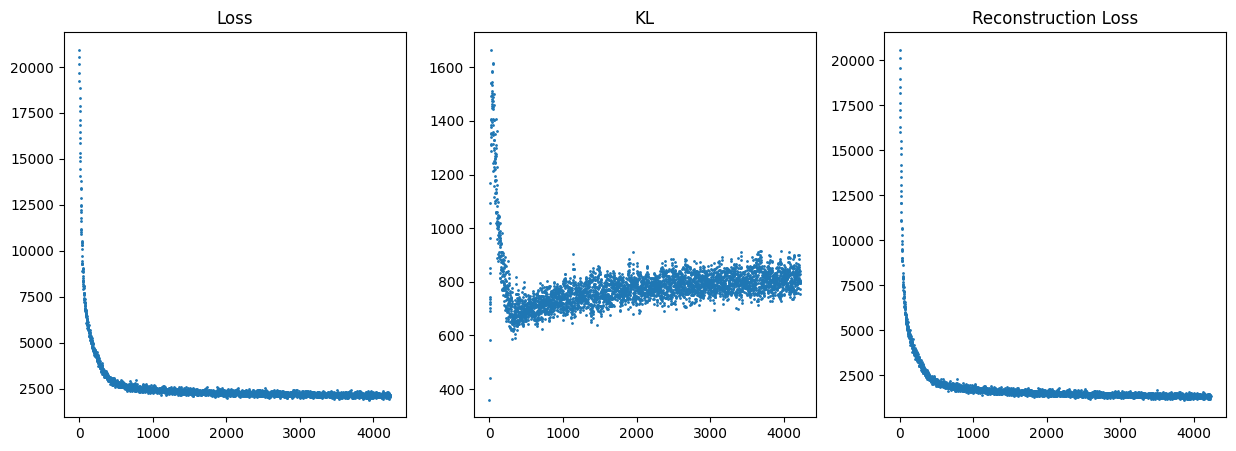

EVALLUATION:
		Plotting ROC curve


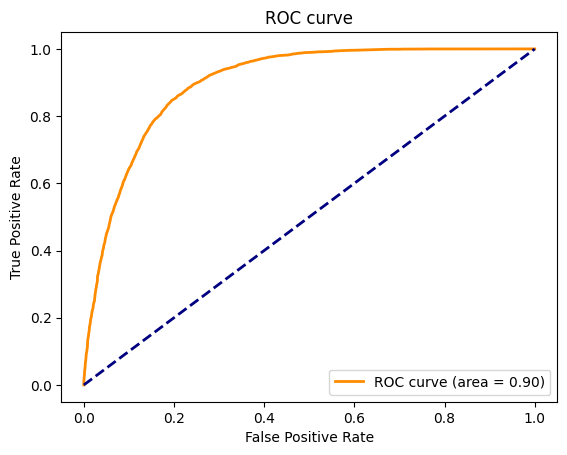

		AUC value = 0.899
		F1 value = 0.809
		AUC PRC value = 0.843


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.899    0.843  0.809                         0.434


TOTAL TIME ELAPSED: 0.73 min





RUNNING: FOR ANOMALY CLASS:  One
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	1
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 53258
    	Length of test dataset 16742
    
TRAINING:
		Time elapsed: 0.13 min
		Time elapsed: 0.26 min
		Time elapsed: 0.39 min
		Time elapsed: 0.52 min
		Time elapsed: 0.65 min
		Total Training Time: 0.65 min
		Plotting training progress



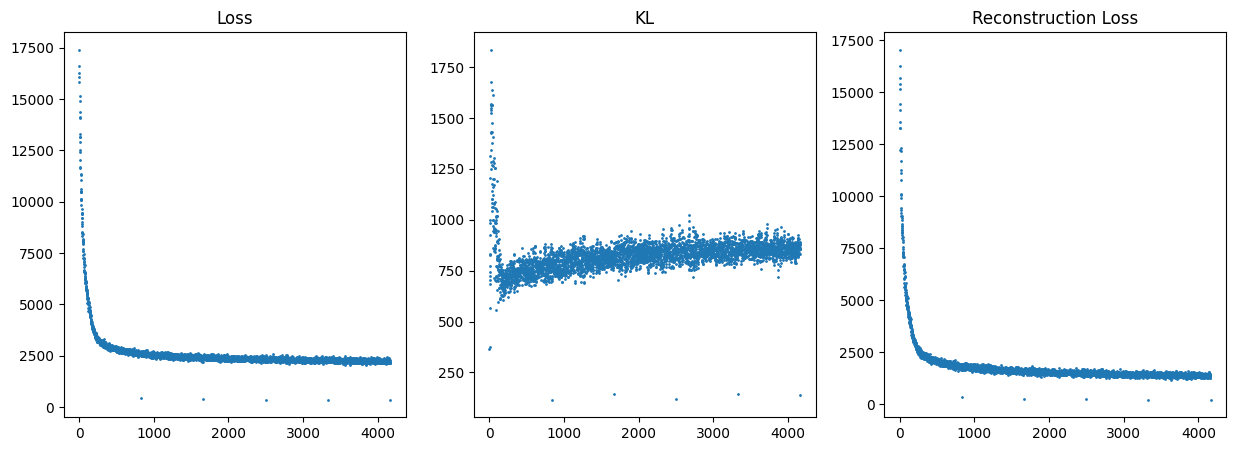

EVALLUATION:
		Plotting ROC curve


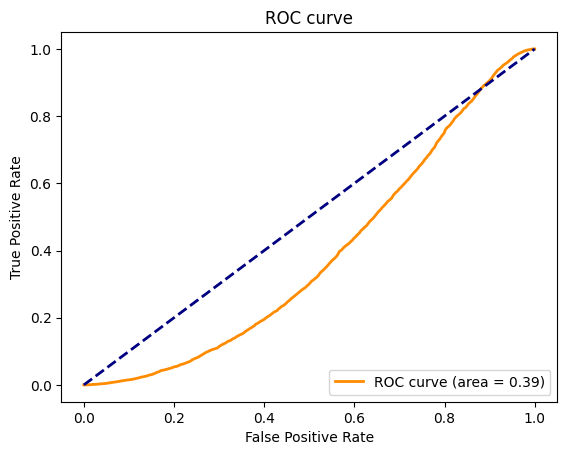

		AUC value = 0.386
		F1 value = 0.643
		AUC PRC value = 0.38


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.899    0.843  0.809                         0.434
1           One  0.386    0.380  0.643                         0.470


TOTAL TIME ELAPSED: 1.48 min





RUNNING: FOR ANOMALY CLASS:  Two
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	2
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 54042
    	Length of test dataset 15958
    
TRAINING:
		Time elapsed: 0.13 min
		Time elapsed: 0.26 min
		Time elapsed: 0.40 min
		Time elapsed: 0.53 min
		Time elapsed: 0.66 min
		Total Training Time: 0.66 min
		Plotting training progress



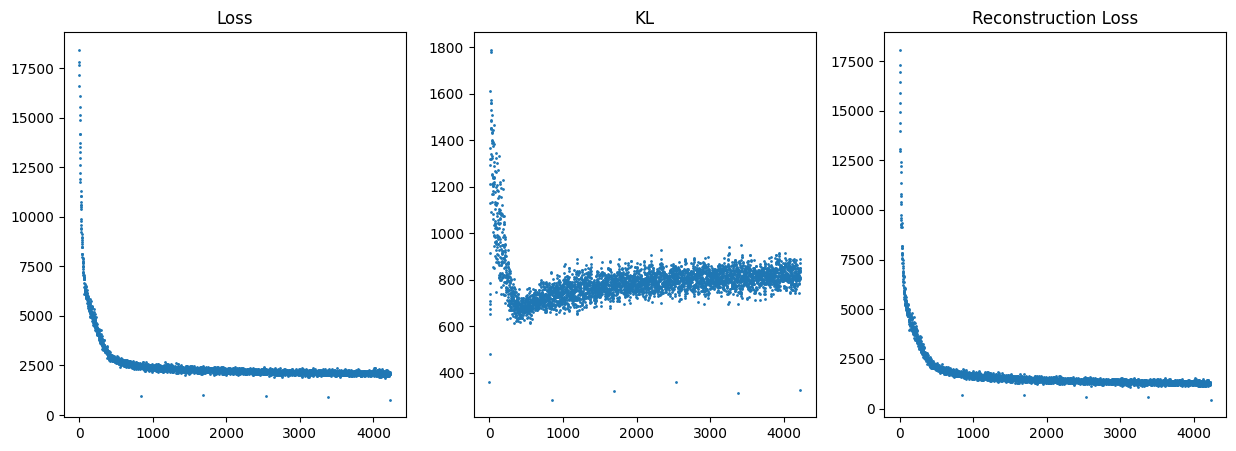

EVALLUATION:
		Plotting ROC curve


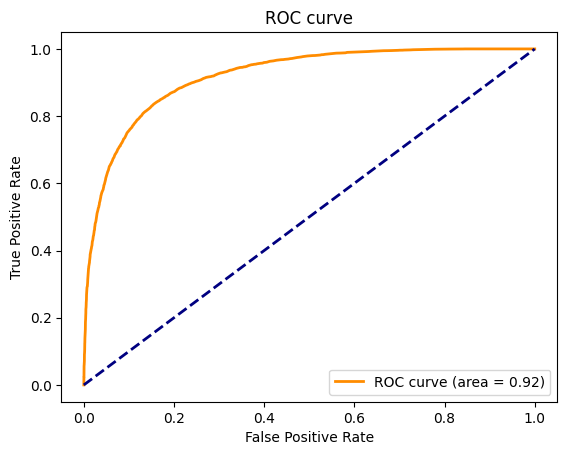

		AUC value = 0.919
		F1 value = 0.822
		AUC PRC value = 0.895


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.899    0.843  0.809                         0.434
1           One  0.386    0.380  0.643                         0.470
2           Two  0.919    0.895  0.822                         0.438


TOTAL TIME ELAPSED: 2.25 min





RUNNING: FOR ANOMALY CLASS:  Three
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	3
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 53869
    	Length of test dataset 16131
    
TRAINING:
		Time elapsed: 0.13 min
		Time elapsed: 0.26 min
		Time elapsed: 0.39 min
		Time elapsed: 0.53 min
		Time elapsed: 0.66 min
		Total Training Time: 0.66 min
		Plotting training progress



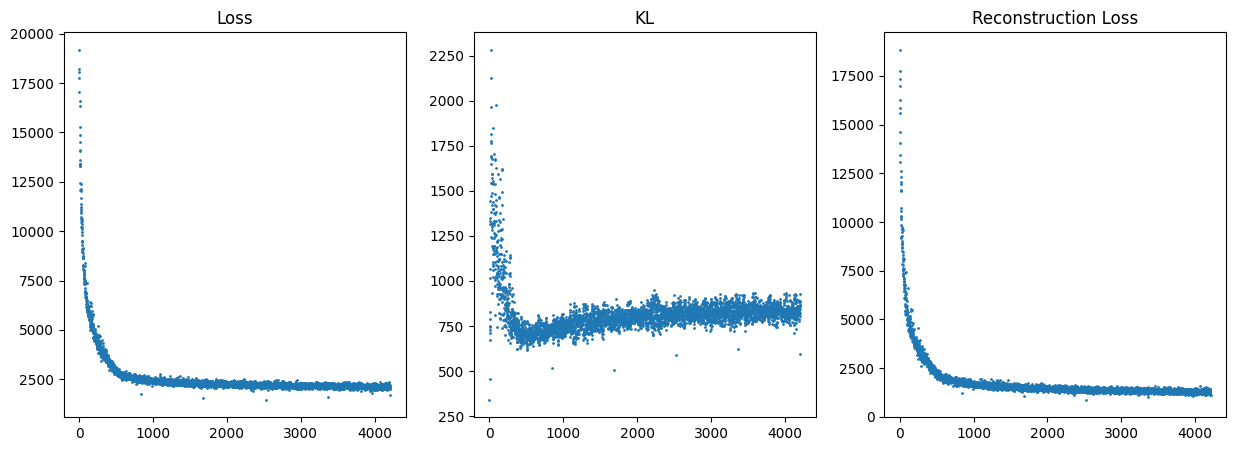

EVALLUATION:
		Plotting ROC curve


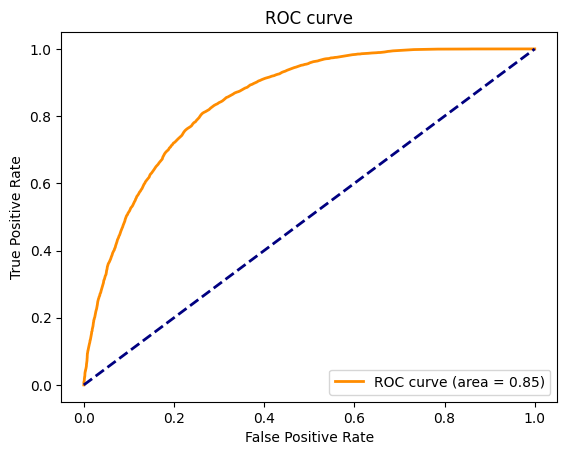

		AUC value = 0.85
		F1 value = 0.759
		AUC PRC value = 0.787


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.899    0.843  0.809                         0.434
1           One  0.386    0.380  0.643                         0.470
2           Two  0.919    0.895  0.822                         0.438
3         Three  0.850    0.787  0.759                         0.443


TOTAL TIME ELAPSED: 3.00 min





RUNNING: FOR ANOMALY CLASS:  Four
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	4
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 54158
    	Length of test dataset 15842
    
TRAINING:
		Time elapsed: 0.13 min
		Time elapsed: 0.26 min
		Time elapsed: 0.40 min
		Time elapsed: 0.53 min
		Time elapsed: 0.67 min
		Total Training Time: 0.67 min
		Plotting training progres

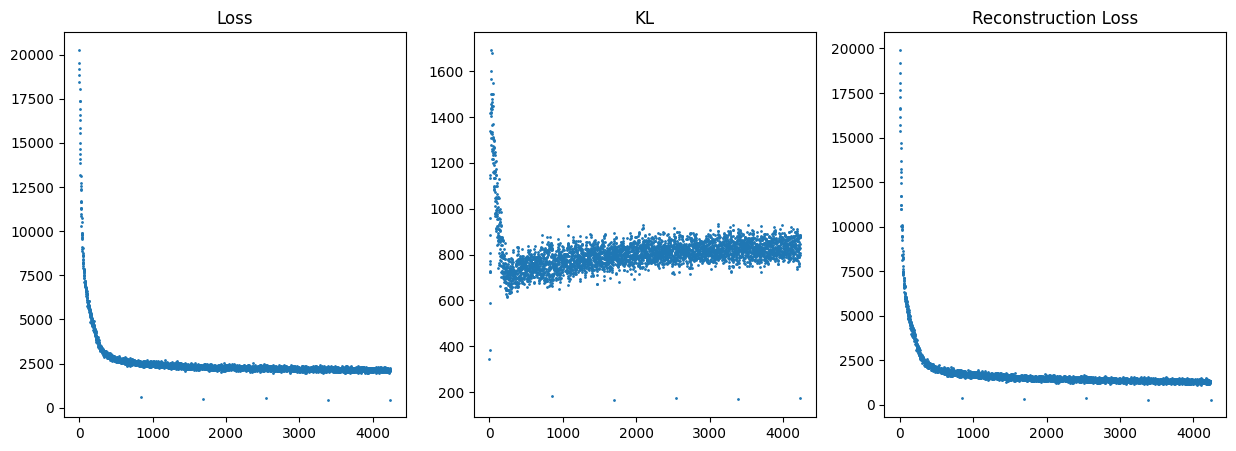

EVALLUATION:
		Plotting ROC curve


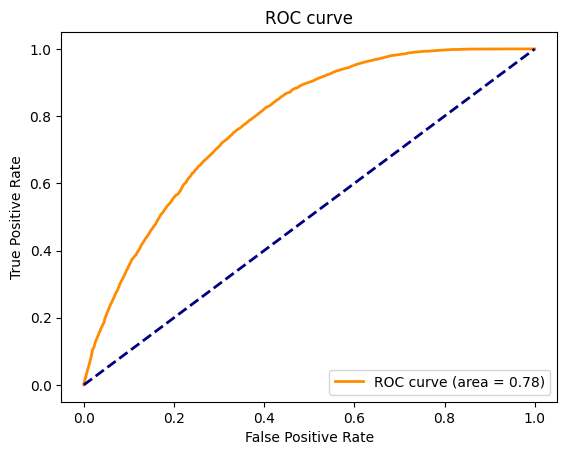

		AUC value = 0.782
		F1 value = 0.706
		AUC PRC value = 0.687


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.899    0.843  0.809                         0.434
1           One  0.386    0.380  0.643                         0.470
2           Two  0.919    0.895  0.822                         0.438
3         Three  0.850    0.787  0.759                         0.443
4          Four  0.782    0.687  0.706                         0.431


TOTAL TIME ELAPSED: 3.77 min





RUNNING: FOR ANOMALY CLASS:  Five
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	5
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 54579
    	Length of test dataset 15421
    
TRAINING:
		Time elapsed: 0.13 min
		Time elapsed: 0.27 min
		Time elapsed: 0.40 min
		Time elapsed: 0.54 min
		Time elapsed

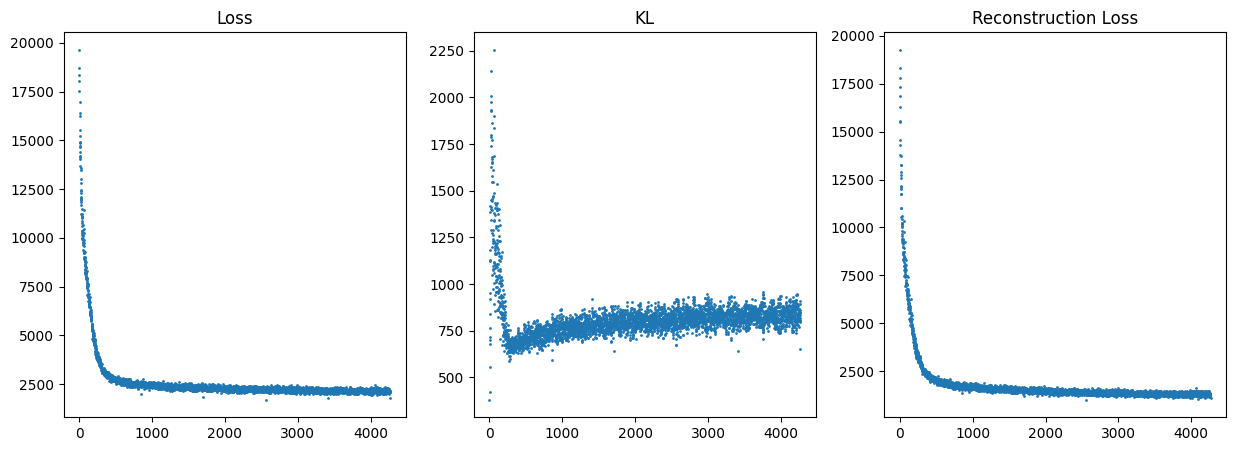

EVALLUATION:
		Plotting ROC curve


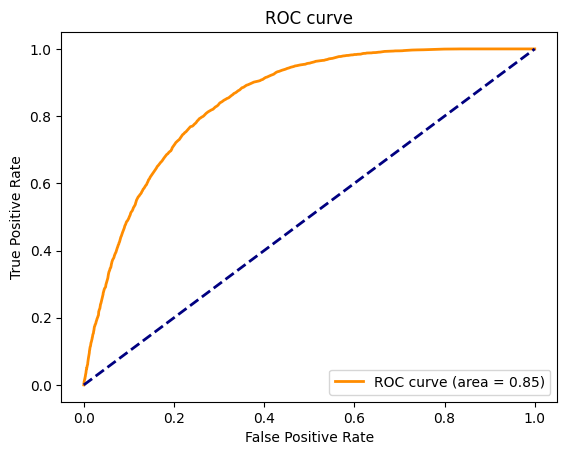

		AUC value = 0.846
		F1 value = 0.74
		AUC PRC value = 0.75


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.899    0.843  0.809                         0.434
1           One  0.386    0.380  0.643                         0.470
2           Two  0.919    0.895  0.822                         0.438
3         Three  0.850    0.787  0.759                         0.443
4          Four  0.782    0.687  0.706                         0.431
5          Five  0.846    0.750  0.740                         0.409


TOTAL TIME ELAPSED: 4.54 min





RUNNING: FOR ANOMALY CLASS:  Six
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	6
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 54082
    	Length of test dataset 15918
    
TRAINING:
		Time elapsed: 0.13 min
		Time elapsed: 0.26 mi

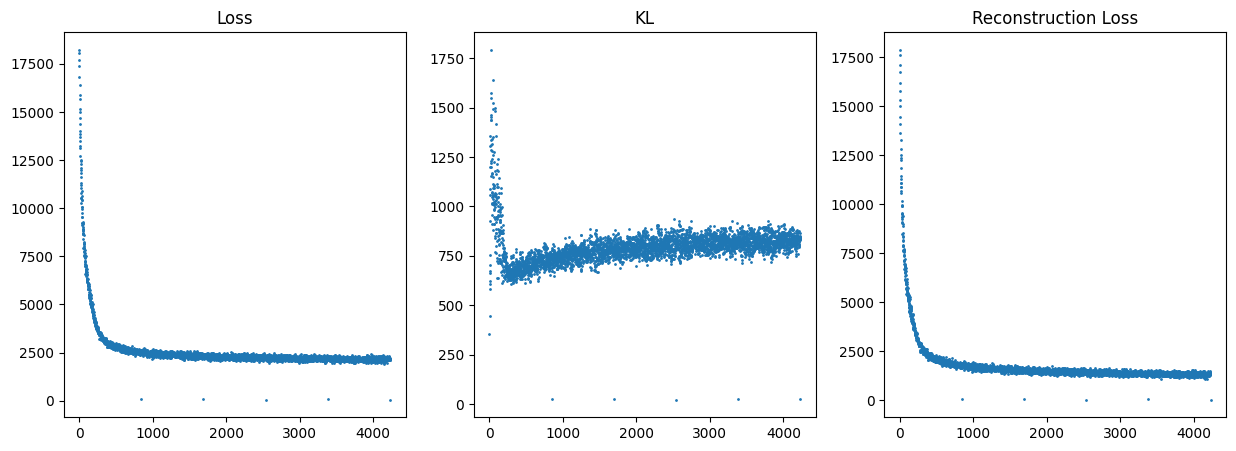

EVALLUATION:
		Plotting ROC curve


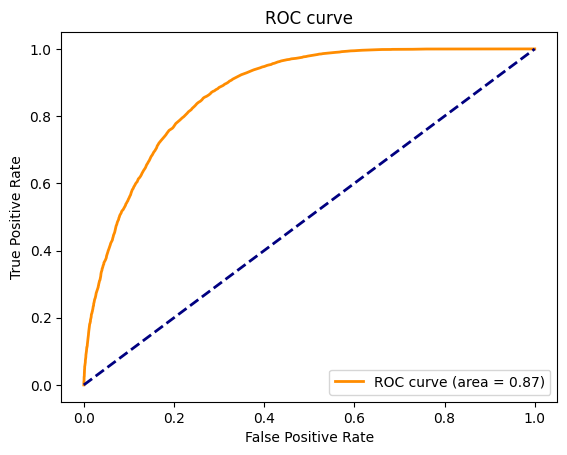

		AUC value = 0.874
		F1 value = 0.777
		AUC PRC value = 0.814


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.899    0.843  0.809                         0.434
1           One  0.386    0.380  0.643                         0.470
2           Two  0.919    0.895  0.822                         0.438
3         Three  0.850    0.787  0.759                         0.443
4          Four  0.782    0.687  0.706                         0.431
5          Five  0.846    0.750  0.740                         0.409
6           Six  0.874    0.814  0.777                         0.432


TOTAL TIME ELAPSED: 5.30 min





RUNNING: FOR ANOMALY CLASS:  Seven
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	7
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 53735
    	Length of test data

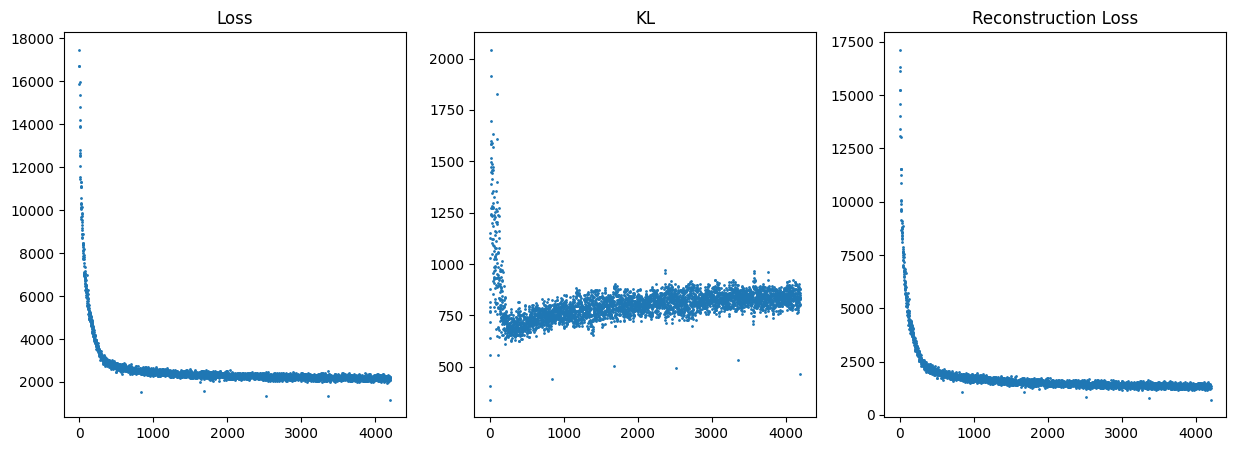

EVALLUATION:
		Plotting ROC curve


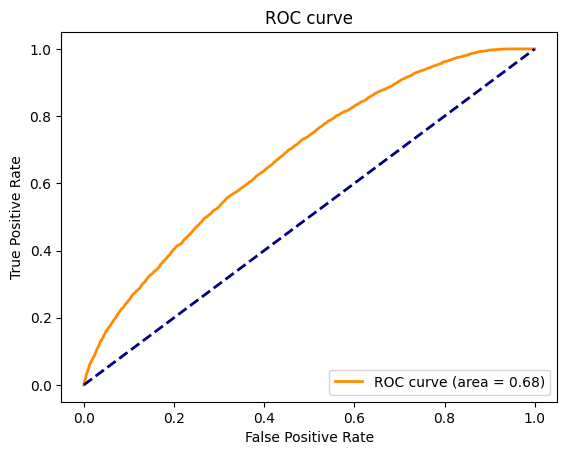

		AUC value = 0.68
		F1 value = 0.656
		AUC PRC value = 0.615


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.899    0.843  0.809                         0.434
1           One  0.386    0.380  0.643                         0.470
2           Two  0.919    0.895  0.822                         0.438
3         Three  0.850    0.787  0.759                         0.443
4          Four  0.782    0.687  0.706                         0.431
5          Five  0.846    0.750  0.740                         0.409
6           Six  0.874    0.814  0.777                         0.432
7         Seven  0.680    0.615  0.656                         0.448


TOTAL TIME ELAPSED: 6.07 min





RUNNING: FOR ANOMALY CLASS:  Eight
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	8
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0

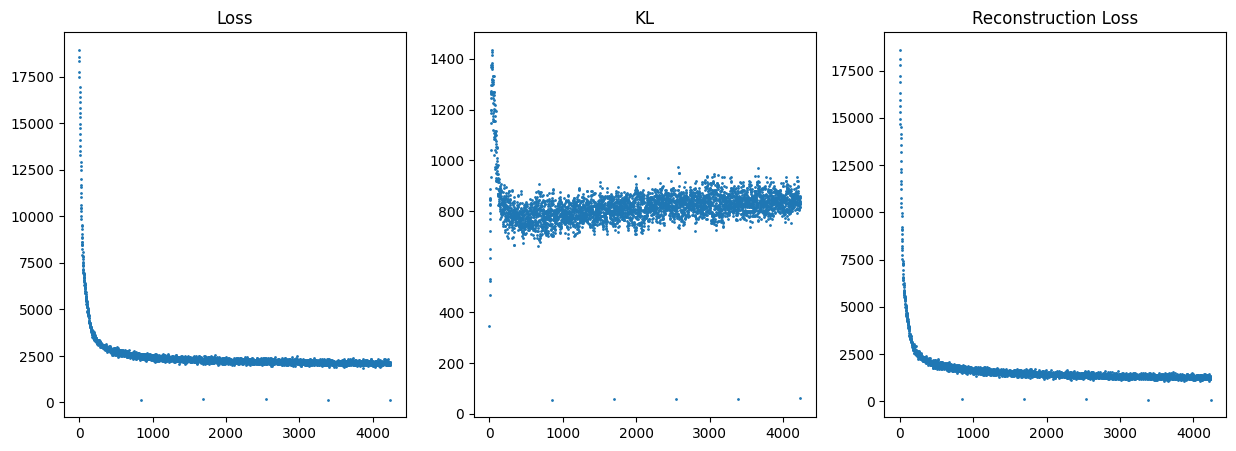

EVALLUATION:
		Plotting ROC curve


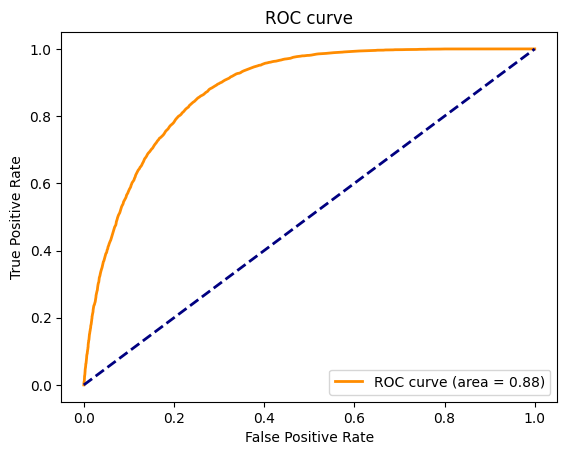

		AUC value = 0.879
		F1 value = 0.783
		AUC PRC value = 0.814


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.899    0.843  0.809                         0.434
1           One  0.386    0.380  0.643                         0.470
2           Two  0.919    0.895  0.822                         0.438
3         Three  0.850    0.787  0.759                         0.443
4          Four  0.782    0.687  0.706                         0.431
5          Five  0.846    0.750  0.740                         0.409
6           Six  0.874    0.814  0.777                         0.432
7         Seven  0.680    0.615  0.656                         0.448
8         Eight  0.879    0.814  0.783                         0.431


TOTAL TIME ELAPSED: 6.83 min





RUNNING: FOR ANOMALY CLASS:  Nine
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly

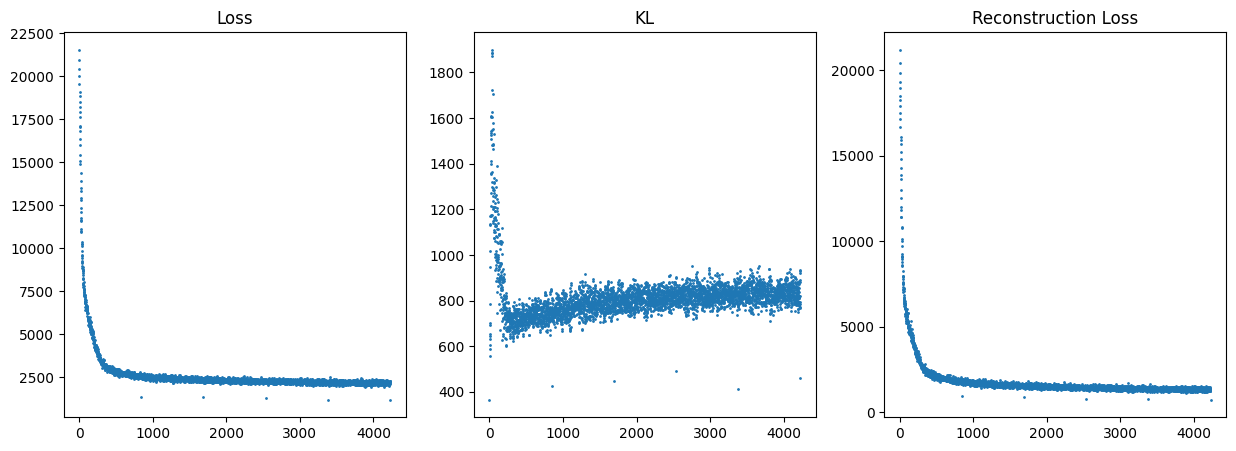

EVALLUATION:
		Plotting ROC curve


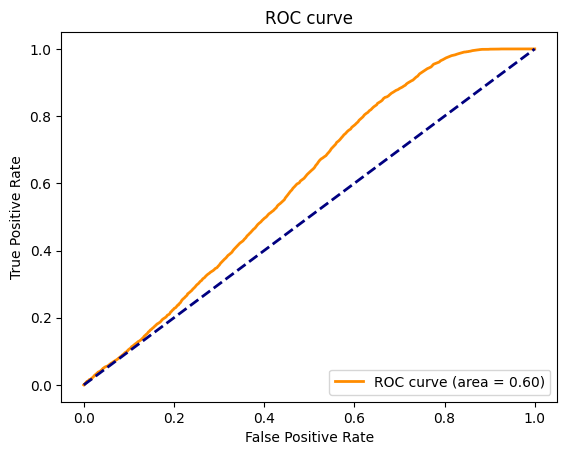

		AUC value = 0.596
		F1 value = 0.646
		AUC PRC value = 0.483


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.899    0.843  0.809                         0.434
1           One  0.386    0.380  0.643                         0.470
2           Two  0.919    0.895  0.822                         0.438
3         Three  0.850    0.787  0.759                         0.443
4          Four  0.782    0.687  0.706                         0.431
5          Five  0.846    0.750  0.740                         0.409
6           Six  0.874    0.814  0.777                         0.432
7         Seven  0.680    0.615  0.656                         0.448
8         Eight  0.879    0.814  0.783                         0.431
9          Nine  0.596    0.483  0.646                         0.436


TOTAL TIME ELAPSED: 7.60 min





FINAL RESULT
  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.899 

In [22]:
main(
    is_model_probabilistic=False,
    model_to_train=ModelToTrain.CNN_MNIST,
    num_epochs=5,
    batch_size=64,
    learning_rate=1e-4,
)

### Exp. 2 - Normal VAE on KDDCup99 

PROCESS ID:		116535

DEVICE:		cuda:1 with 4 workers.

RUNNING: FOR ANOMALY CLASS:  Normal
------------------------------------------------


HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.FULLY_TABULAR
    	Anomaly class:	StrIntMapping(label='normal', encoded=0)
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	1e-05
    	Length of training dataset 315800
    	Length of test dataset 176018
    
TRAINING:
		Time elapsed: 0.21 min
		Time elapsed: 0.42 min
		Time elapsed: 0.63 min
		Time elapsed: 0.84 min
		Time elapsed: 1.06 min
		Total Training Time: 1.06 min
		Plotting training progress



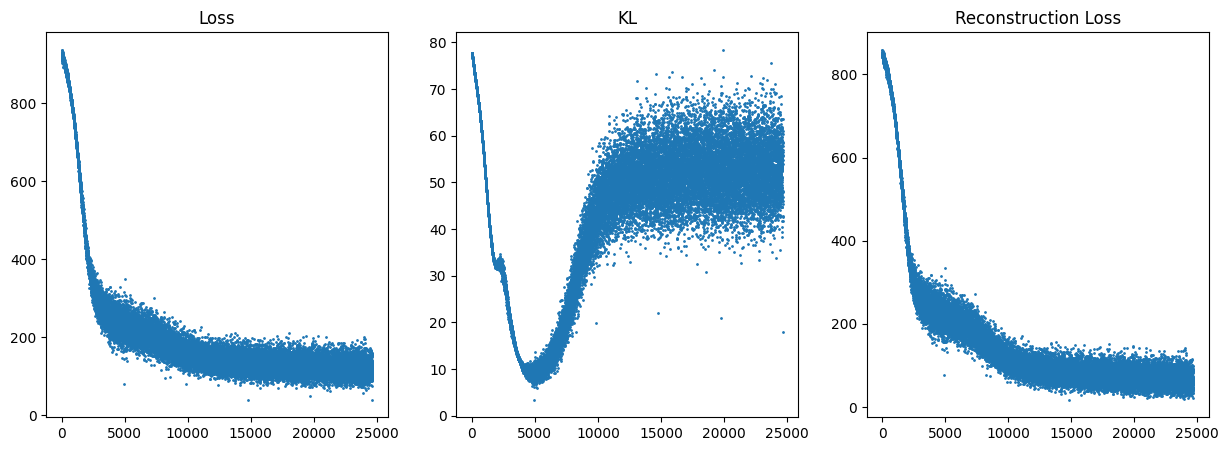

EVALLUATION:
		Plotting ROC curve


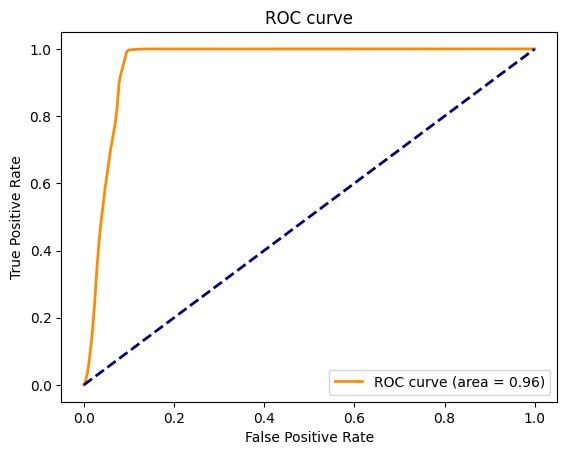

		AUC value = 0.956
		F1 value = 0.959
		AUC PRC value = 0.923


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.956    0.923  0.959                         0.553


TOTAL TIME ELAPSED: 1.94 min





RUNNING: FOR ANOMALY CLASS:  Probe
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.FULLY_TABULAR
    	Anomaly class:	StrIntMapping(label='probe', encoded=1)
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	1e-05
    	Length of training dataset 390188
    	Length of test dataset 101630
    
TRAINING:
		Time elapsed: 0.26 min
		Time elapsed: 0.51 min
		Time elapsed: 0.77 min
		Time elapsed: 1.03 min
		Time elapsed: 1.30 min
		Total Training Time: 1.30 min
		Plotting training progress



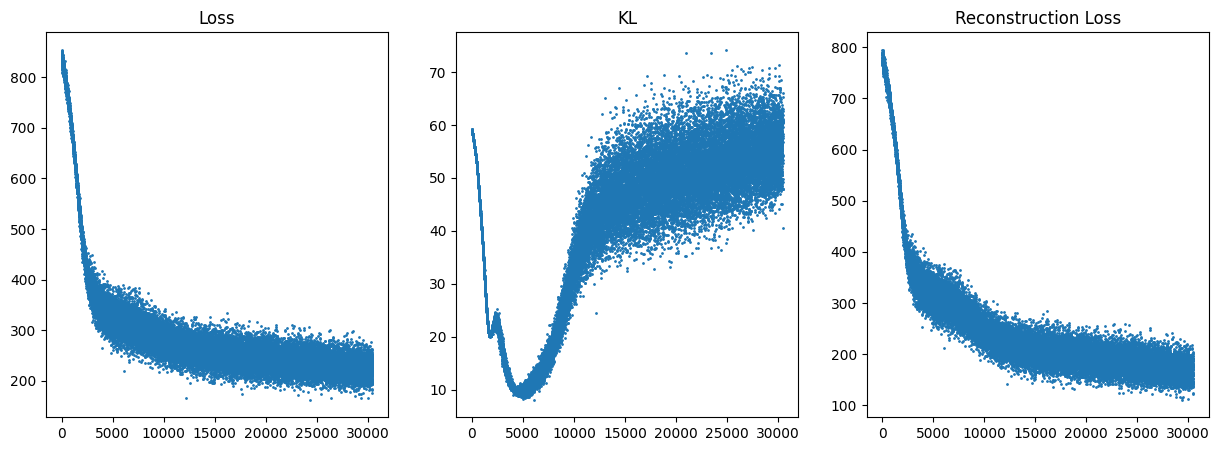

EVALLUATION:
		Plotting ROC curve


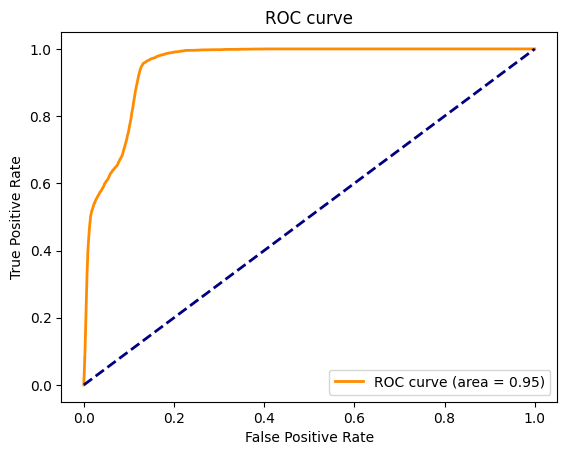

		AUC value = 0.951
		F1 value = 0.54
		AUC PRC value = 0.465


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.956    0.923  0.959                         0.553
1         Probe  0.951    0.465  0.540                         0.040


TOTAL TIME ELAPSED: 3.73 min





RUNNING: FOR ANOMALY CLASS:  DoS
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.FULLY_TABULAR
    	Anomaly class:	StrIntMapping(label='dos', encoded=2)
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	1e-05
    	Length of training dataset 81865
    	Length of test dataset 409953
    
TRAINING:
		Time elapsed: 0.06 min
		Time elapsed: 0.12 min
		Time elapsed: 0.17 min
		Time elapsed: 0.23 min
		Time elapsed: 0.29 min
		Total Training Time: 0.29 min
		Plotting training progress



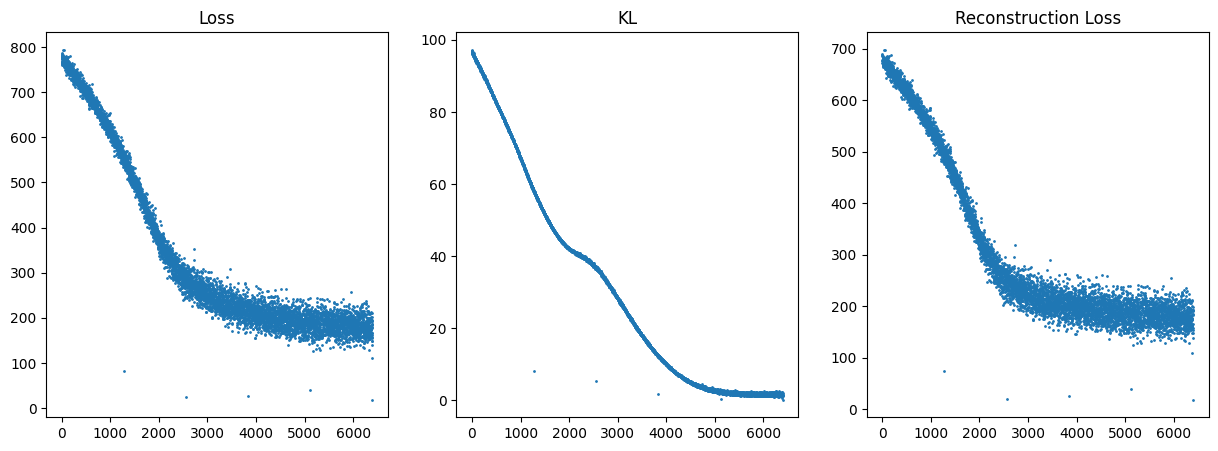

EVALLUATION:
		Plotting ROC curve


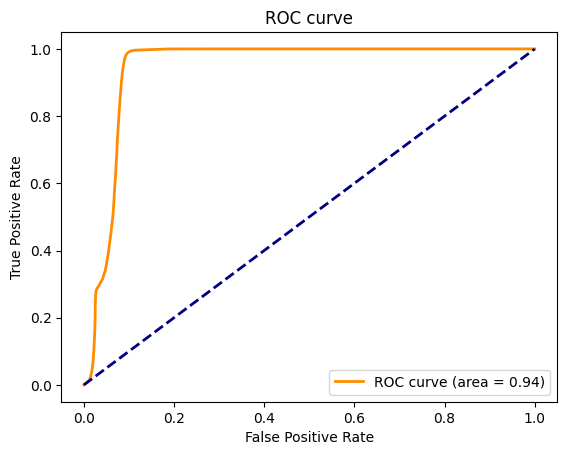

		AUC value = 0.944
		F1 value = 0.995
		AUC PRC value = 0.992


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.956    0.923  0.959                         0.553
1         Probe  0.951    0.465  0.540                         0.040
2           DoS  0.944    0.992  0.995                         0.950


TOTAL TIME ELAPSED: 5.72 min





RUNNING: FOR ANOMALY CLASS:  U2R
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.FULLY_TABULAR
    	Anomaly class:	StrIntMapping(label='u2r', encoded=3)
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	1e-05
    	Length of training dataset 393411
    	Length of test dataset 98407
    
TRAINING:
		Time elapsed: 0.26 min
		Time elapsed: 0.53 min
		Time elapsed: 0.79 min
		Time elapsed: 1.05 min
		Time elapsed: 1.32 min
		Total Training Time: 1.32 min
		Plotting training progress



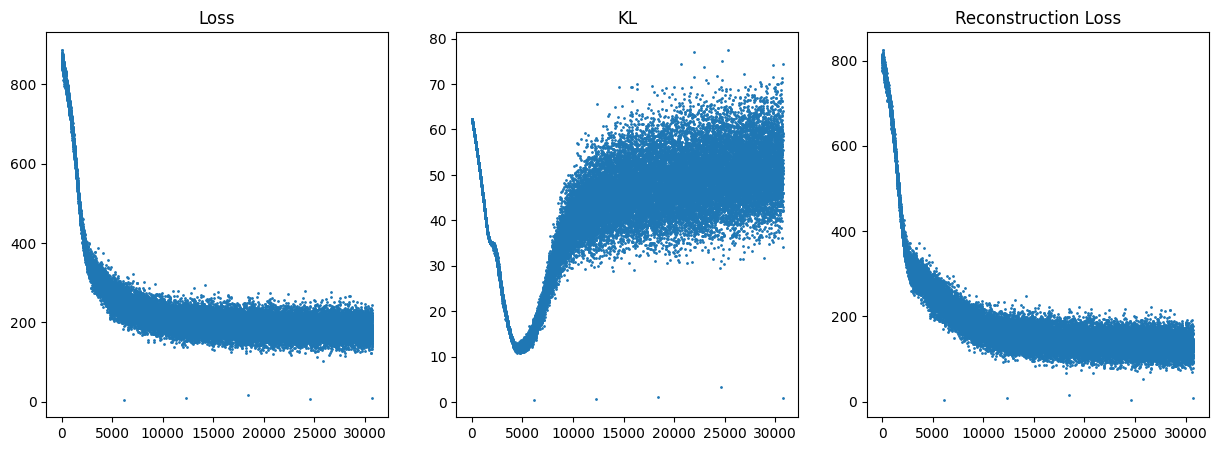

EVALLUATION:
		Plotting ROC curve


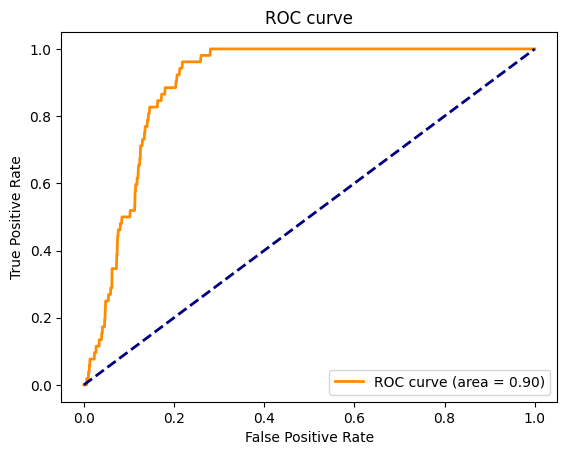

		AUC value = 0.898
		F1 value = 0.006
		AUC PRC value = 0.003


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.956    0.923  0.959                         0.553
1         Probe  0.951    0.465  0.540                         0.040
2           DoS  0.944    0.992  0.995                         0.950
3           U2R  0.898    0.003  0.006                         0.001


TOTAL TIME ELAPSED: 7.49 min





RUNNING: FOR ANOMALY CLASS:  R2L
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	False
    	Model:			ModelToTrain.FULLY_TABULAR
    	Anomaly class:	StrIntMapping(label='r2l', encoded=4)
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	1e-05
    	Length of training dataset 392552
    	Length of test dataset 99266
    
TRAINING:
		Time elapsed: 0.26 min
		Time elapsed: 0.52 min
		Time elapsed: 0.78 min
		Time elapsed: 1.04 min
		Time elapsed: 1.30 min
		Total Training Ti

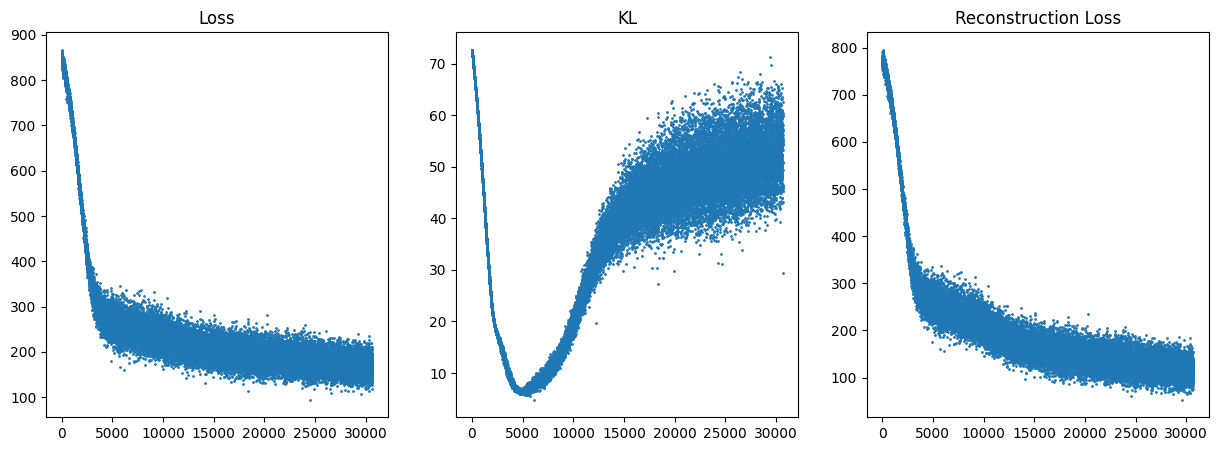

EVALLUATION:
		Plotting ROC curve


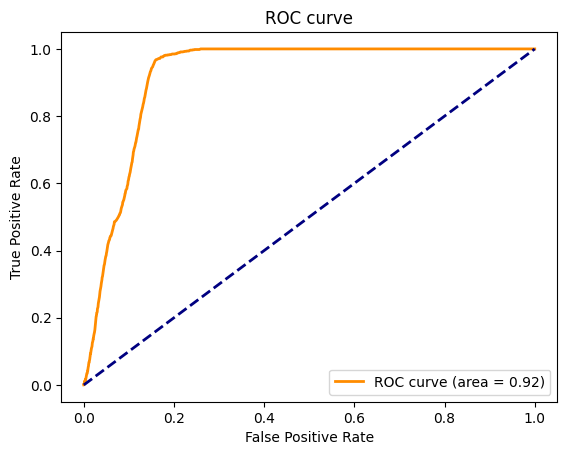

		AUC value = 0.922
		F1 value = 0.138
		AUC PRC value = 0.07


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.956    0.923  0.959                         0.553
1         Probe  0.951    0.465  0.540                         0.040
2           DoS  0.944    0.992  0.995                         0.950
3           U2R  0.898    0.003  0.006                         0.001
4           R2L  0.922    0.070  0.138                         0.011


TOTAL TIME ELAPSED: 9.24 min





FINAL RESULT
  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.956    0.923  0.959                         0.553
1         Probe  0.951    0.465  0.540                         0.040
2           DoS  0.944    0.992  0.995                         0.950
3           U2R  0.898    0.003  0.006                         0.001
4           R2L  0.922    0.070  0.138                         0.011


Script finished.


In [23]:
main(
    is_model_probabilistic=False,
    model_to_train=ModelToTrain.FULLY_TABULAR,
    num_epochs=5,
    batch_size=64,
    learning_rate=1e-5,
)

### Exp. 3 - Probabilistic VAE on MNIST 

PROCESS ID:		116535

DEVICE:		cuda:1 with 4 workers.

RUNNING: FOR ANOMALY CLASS:  Zero
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	0
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 54077
    	Length of test dataset 15923
    
TRAINING:
		Time elapsed: 0.14 min
		Time elapsed: 0.29 min
		Time elapsed: 0.43 min
		Time elapsed: 0.57 min
		Time elapsed: 0.72 min
		Total Training Time: 0.72 min
		Plotting training progress



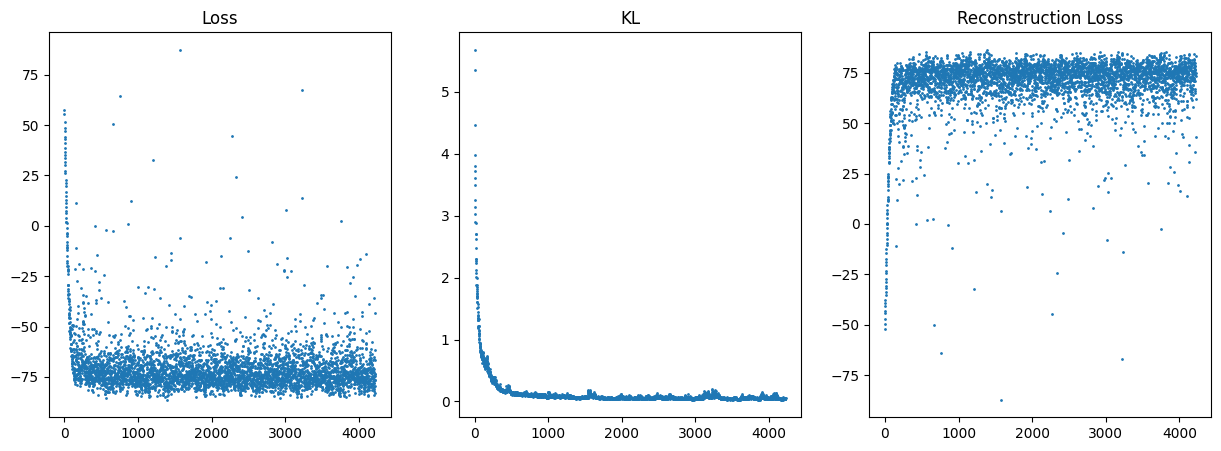

EVALLUATION:
		Plotting ROC curve


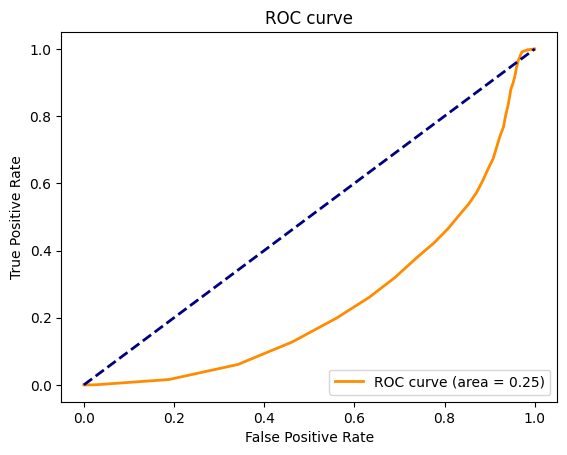

		AUC value = 0.251
		F1 value = 0.608
		AUC PRC value = 0.309


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.251    0.309  0.608                         0.434


TOTAL TIME ELAPSED: 0.76 min





RUNNING: FOR ANOMALY CLASS:  One
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	1
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 53258
    	Length of test dataset 16742
    
TRAINING:
		Time elapsed: 0.15 min
		Time elapsed: 0.29 min
		Time elapsed: 0.44 min
		Time elapsed: 0.59 min
		Time elapsed: 0.74 min
		Total Training Time: 0.74 min
		Plotting training progress



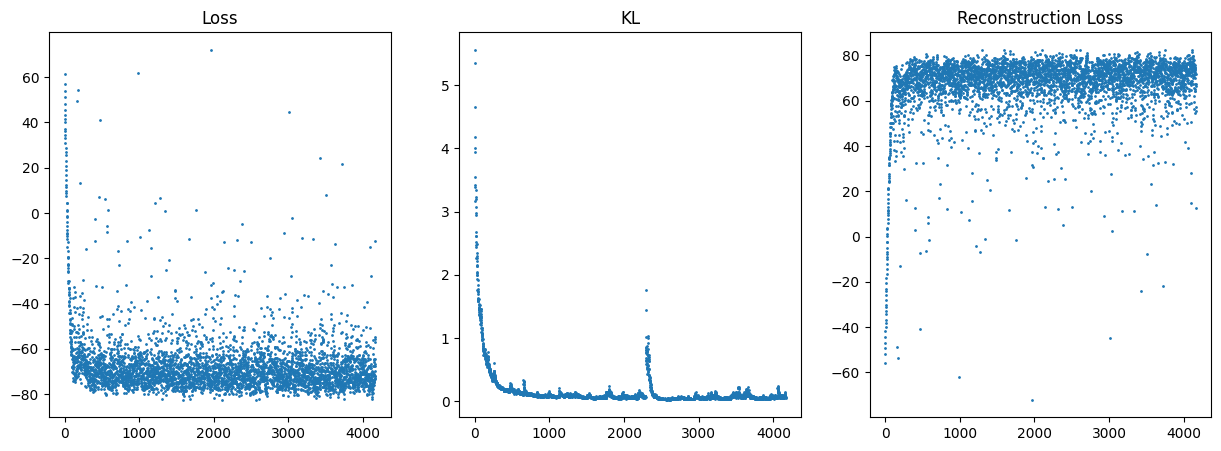

EVALLUATION:
		Plotting ROC curve


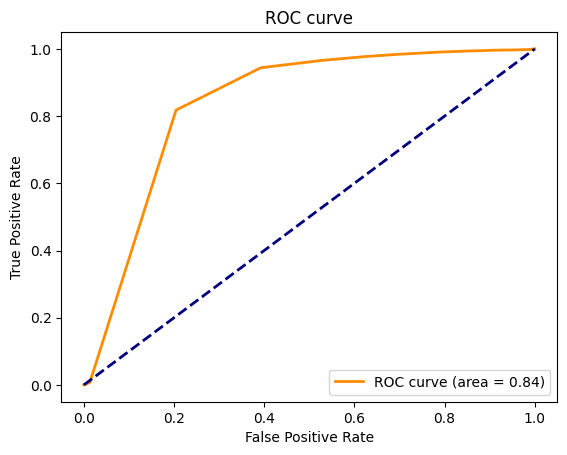

		AUC value = 0.84
		F1 value = 0.799
		AUC PRC value = 0.753


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.251    0.309  0.608                         0.434
1           One  0.840    0.753  0.799                         0.470


TOTAL TIME ELAPSED: 1.55 min





RUNNING: FOR ANOMALY CLASS:  Two
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	2
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 54042
    	Length of test dataset 15958
    
TRAINING:
		Time elapsed: 0.15 min
		Time elapsed: 0.30 min
		Time elapsed: 0.45 min
		Time elapsed: 0.60 min
		Time elapsed: 0.75 min
		Total Training Time: 0.75 min
		Plotting training progress



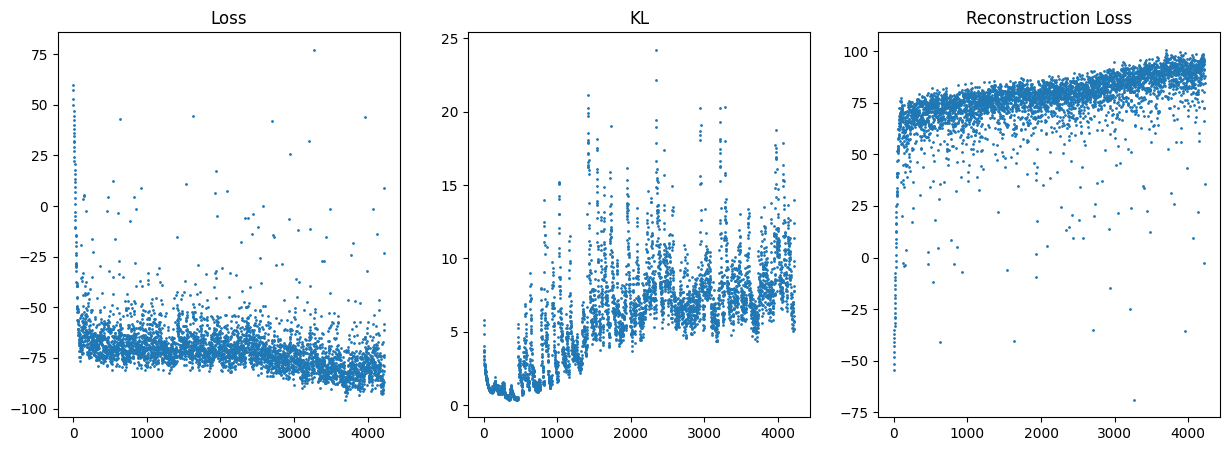

EVALLUATION:
		Plotting ROC curve


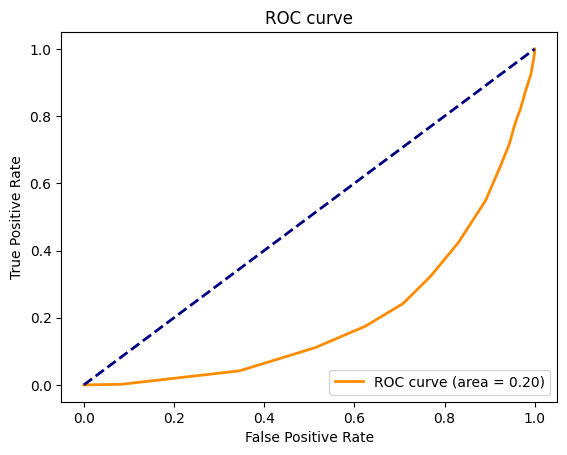

		AUC value = 0.202
		F1 value = 0.609
		AUC PRC value = 0.305


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.251    0.309  0.608                         0.434
1           One  0.840    0.753  0.799                         0.470
2           Two  0.202    0.305  0.609                         0.438


TOTAL TIME ELAPSED: 2.35 min





RUNNING: FOR ANOMALY CLASS:  Three
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	3
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 53869
    	Length of test dataset 16131
    
TRAINING:
		Time elapsed: 0.15 min
		Time elapsed: 0.30 min
		Time elapsed: 0.45 min
		Time elapsed: 0.60 min
		Time elapsed: 0.75 min
		Total Training Time: 0.75 min
		Plotting training progress



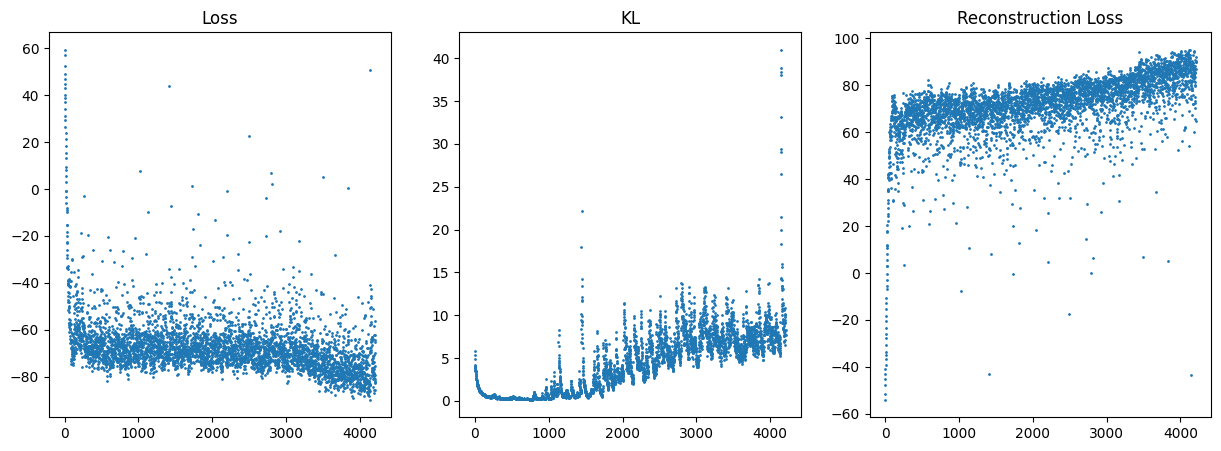

EVALLUATION:
		Plotting ROC curve


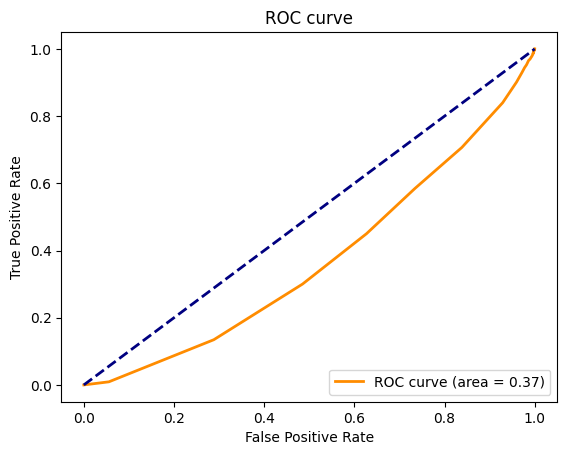

		AUC value = 0.371
		F1 value = 0.614
		AUC PRC value = 0.37


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.251    0.309  0.608                         0.434
1           One  0.840    0.753  0.799                         0.470
2           Two  0.202    0.305  0.609                         0.438
3         Three  0.371    0.370  0.614                         0.443


TOTAL TIME ELAPSED: 3.15 min





RUNNING: FOR ANOMALY CLASS:  Four
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	4
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 54158
    	Length of test dataset 15842
    
TRAINING:
		Time elapsed: 0.15 min
		Time elapsed: 0.30 min
		Time elapsed: 0.46 min
		Time elapsed: 0.61 min
		Time elapsed: 0.76 min
		Total Training Time: 0.76 min
		Plotting training progress

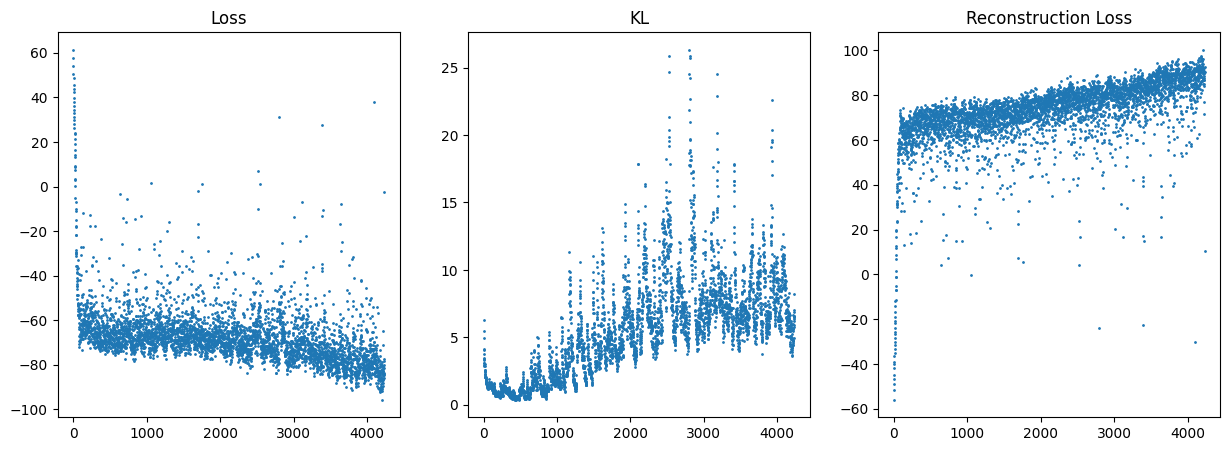

EVALLUATION:
		Plotting ROC curve


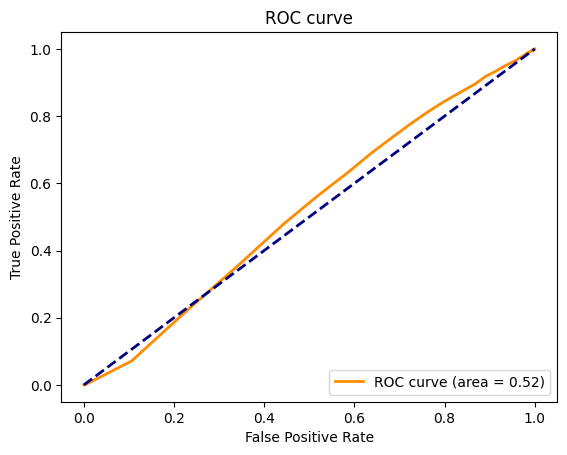

		AUC value = 0.52
		F1 value = 0.602
		AUC PRC value = 0.434


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.251    0.309  0.608                         0.434
1           One  0.840    0.753  0.799                         0.470
2           Two  0.202    0.305  0.609                         0.438
3         Three  0.371    0.370  0.614                         0.443
4          Four  0.520    0.434  0.602                         0.431


TOTAL TIME ELAPSED: 3.95 min





RUNNING: FOR ANOMALY CLASS:  Five
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	5
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 54579
    	Length of test dataset 15421
    
TRAINING:
		Time elapsed: 0.15 min
		Time elapsed: 0.31 min
		Time elapsed: 0.46 min
		Time elapsed: 0.62 min
		Time elapsed: 

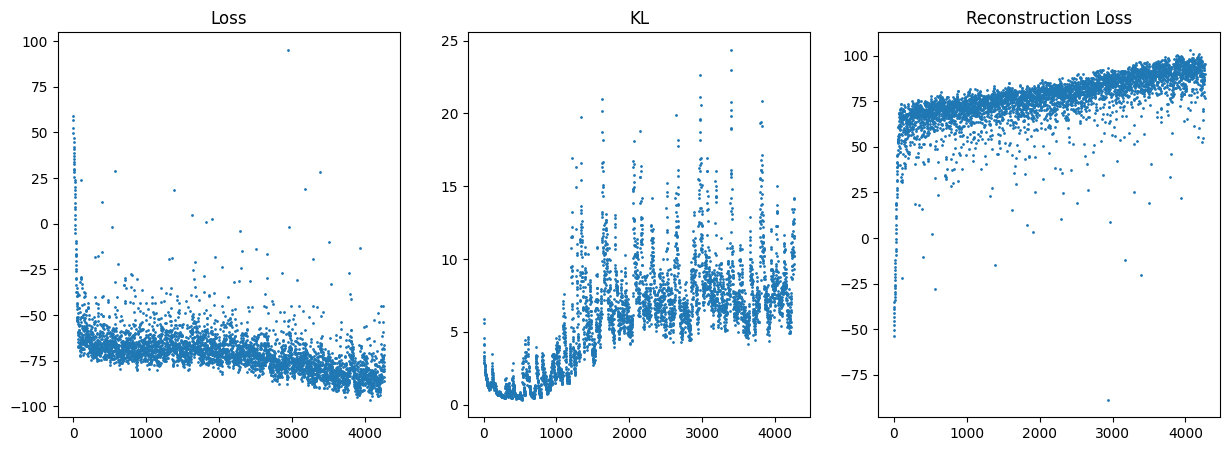

EVALLUATION:
		Plotting ROC curve


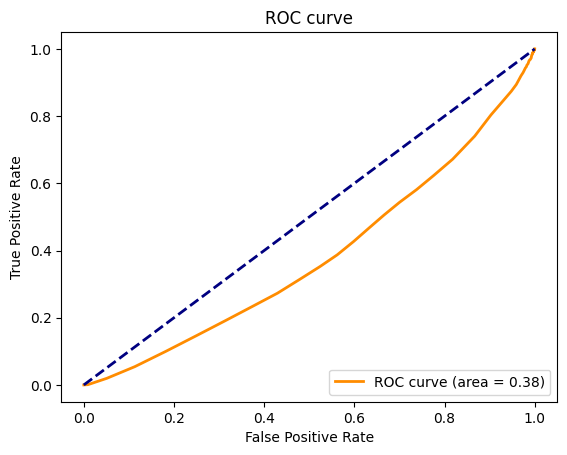

		AUC value = 0.382
		F1 value = 0.581
		AUC PRC value = 0.34


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.251    0.309  0.608                         0.434
1           One  0.840    0.753  0.799                         0.470
2           Two  0.202    0.305  0.609                         0.438
3         Three  0.371    0.370  0.614                         0.443
4          Four  0.520    0.434  0.602                         0.431
5          Five  0.382    0.340  0.581                         0.409


TOTAL TIME ELAPSED: 4.77 min





RUNNING: FOR ANOMALY CLASS:  Six
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	6
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 54082
    	Length of test dataset 15918
    
TRAINING:
		Time elapsed: 0.15 min
		Time elapsed: 0.30 mi

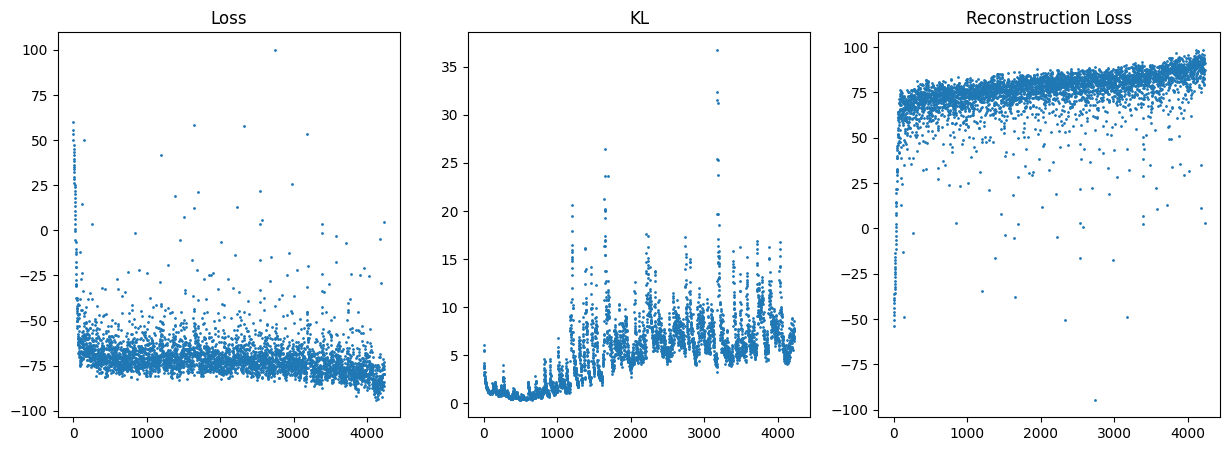

EVALLUATION:
		Plotting ROC curve


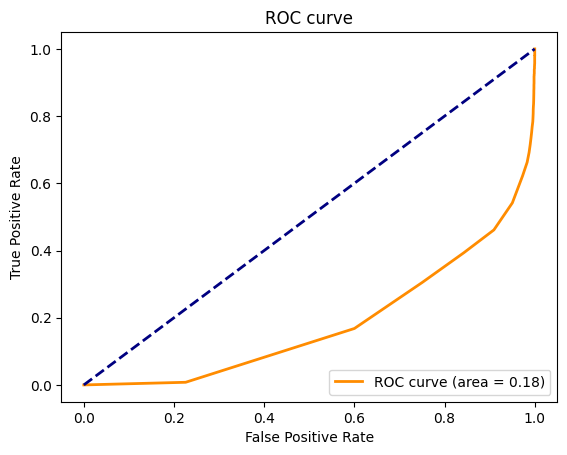

		AUC value = 0.183
		F1 value = 0.603
		AUC PRC value = 0.298


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.251    0.309  0.608                         0.434
1           One  0.840    0.753  0.799                         0.470
2           Two  0.202    0.305  0.609                         0.438
3         Three  0.371    0.370  0.614                         0.443
4          Four  0.520    0.434  0.602                         0.431
5          Five  0.382    0.340  0.581                         0.409
6           Six  0.183    0.298  0.603                         0.432


TOTAL TIME ELAPSED: 5.58 min





RUNNING: FOR ANOMALY CLASS:  Seven
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	7
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0.0001
    	Length of training dataset 53735
    	Length of test datas

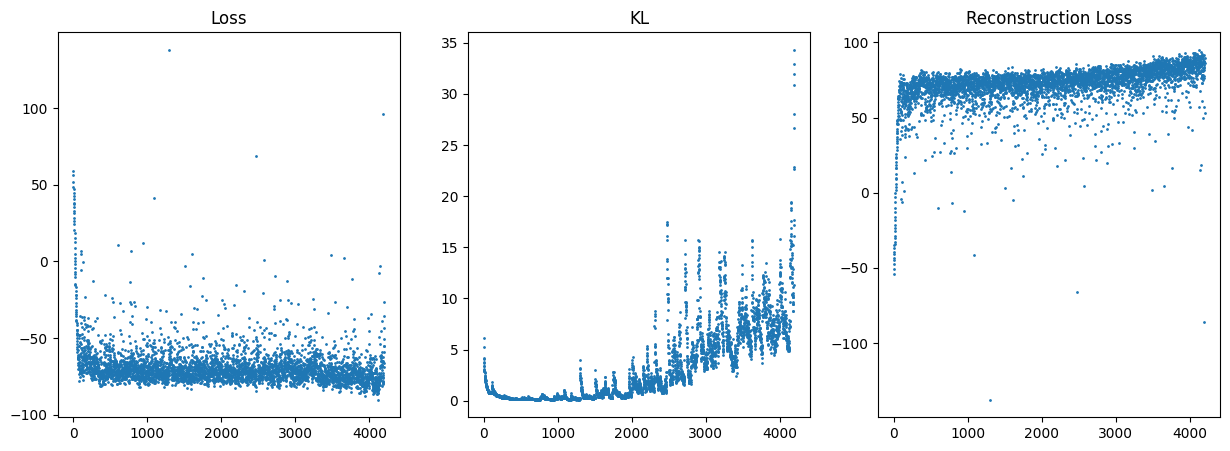

EVALLUATION:
		Plotting ROC curve


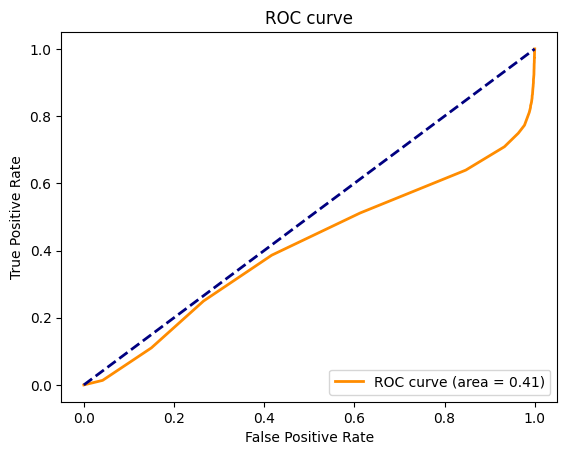

		AUC value = 0.408
		F1 value = 0.619
		AUC PRC value = 0.404


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.251    0.309  0.608                         0.434
1           One  0.840    0.753  0.799                         0.470
2           Two  0.202    0.305  0.609                         0.438
3         Three  0.371    0.370  0.614                         0.443
4          Four  0.520    0.434  0.602                         0.431
5          Five  0.382    0.340  0.581                         0.409
6           Six  0.183    0.298  0.603                         0.432
7         Seven  0.408    0.404  0.619                         0.448


TOTAL TIME ELAPSED: 6.39 min





RUNNING: FOR ANOMALY CLASS:  Eight
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly class:	8
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	0

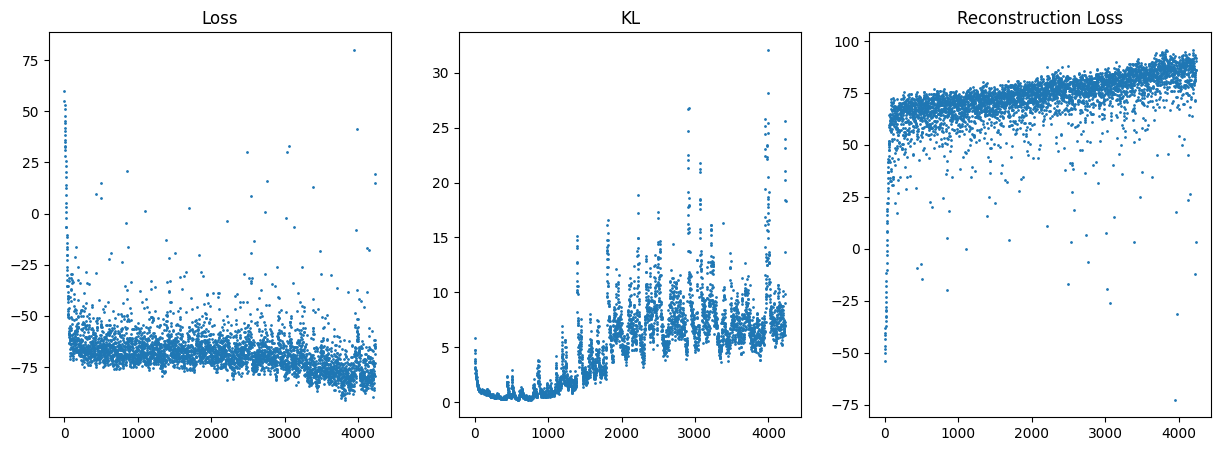

EVALLUATION:
		Plotting ROC curve


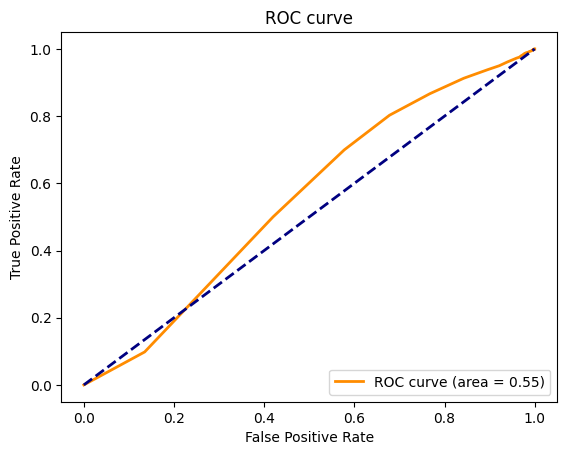

		AUC value = 0.553
		F1 value = 0.603
		AUC PRC value = 0.458


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.251    0.309  0.608                         0.434
1           One  0.840    0.753  0.799                         0.470
2           Two  0.202    0.305  0.609                         0.438
3         Three  0.371    0.370  0.614                         0.443
4          Four  0.520    0.434  0.602                         0.431
5          Five  0.382    0.340  0.581                         0.409
6           Six  0.183    0.298  0.603                         0.432
7         Seven  0.408    0.404  0.619                         0.448
8         Eight  0.553    0.458  0.603                         0.431


TOTAL TIME ELAPSED: 7.20 min





RUNNING: FOR ANOMALY CLASS:  Nine
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.CNN_MNIST
    	Anomaly 

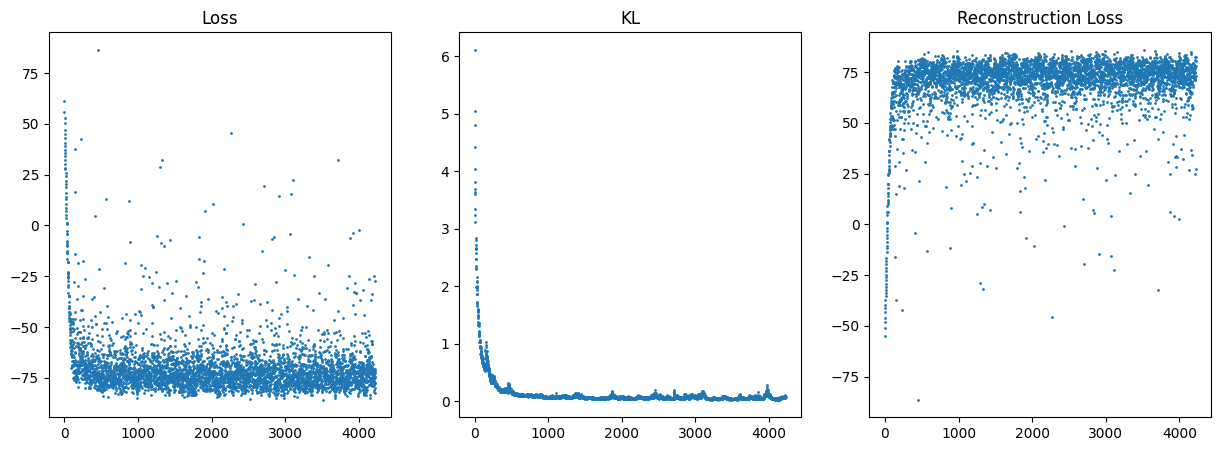

EVALLUATION:
		Plotting ROC curve


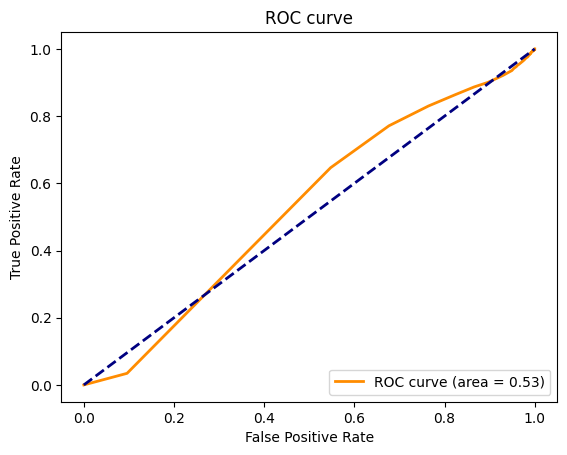

		AUC value = 0.529
		F1 value = 0.608
		AUC PRC value = 0.452


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.251    0.309  0.608                         0.434
1           One  0.840    0.753  0.799                         0.470
2           Two  0.202    0.305  0.609                         0.438
3         Three  0.371    0.370  0.614                         0.443
4          Four  0.520    0.434  0.602                         0.431
5          Five  0.382    0.340  0.581                         0.409
6           Six  0.183    0.298  0.603                         0.432
7         Seven  0.408    0.404  0.619                         0.448
8         Eight  0.553    0.458  0.603                         0.431
9          Nine  0.529    0.452  0.608                         0.436


TOTAL TIME ELAPSED: 8.01 min





FINAL RESULT
  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0          Zero  0.251 

In [24]:
main(
    is_model_probabilistic=True,
    model_to_train=ModelToTrain.CNN_MNIST,
    num_epochs=5,
    batch_size=64,
    learning_rate=1e-4,
)

### Exp. 4 - Probabilistic VAE on KDDCup99 

PROCESS ID:		116535

DEVICE:		cuda:1 with 4 workers.

RUNNING: FOR ANOMALY CLASS:  Normal
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.FULLY_TABULAR
    	Anomaly class:	StrIntMapping(label='normal', encoded=0)
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	1e-05
    	Length of training dataset 315800
    	Length of test dataset 176018
    
TRAINING:
		Time elapsed: 0.27 min
		Time elapsed: 0.53 min
		Time elapsed: 0.80 min
		Time elapsed: 1.06 min
		Time elapsed: 1.33 min
		Total Training Time: 1.33 min
		Plotting training progress



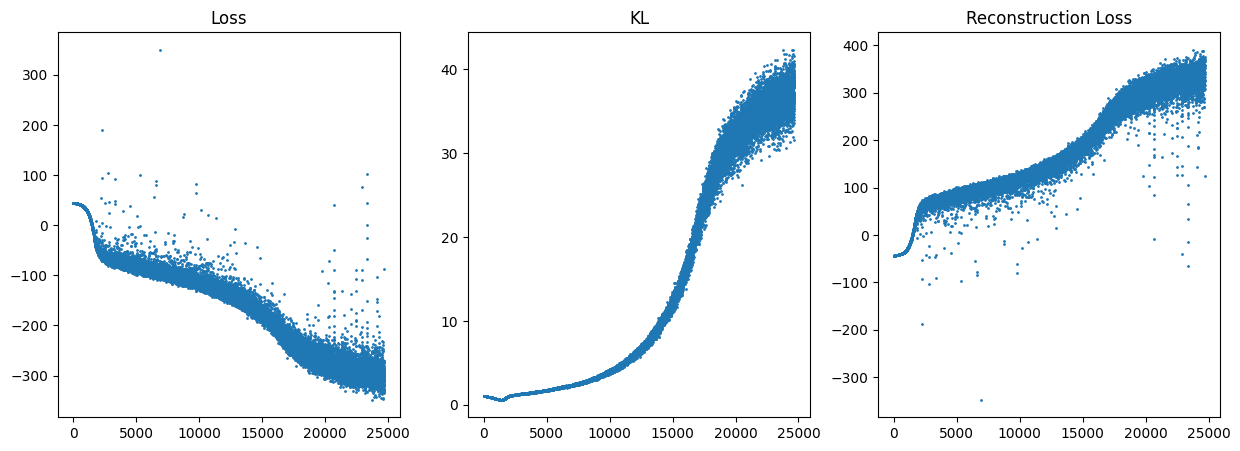

EVALLUATION:
		Plotting ROC curve


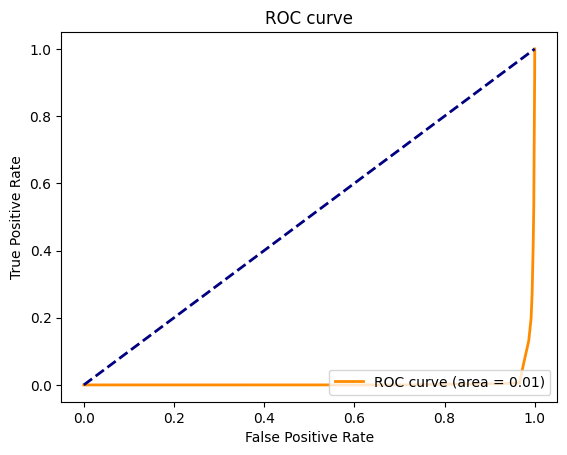

		AUC value = 0.006
		F1 value = 0.712
		AUC PRC value = 0.364


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.006    0.364  0.712                         0.553


TOTAL TIME ELAPSED: 1.75 min





RUNNING: FOR ANOMALY CLASS:  Probe
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.FULLY_TABULAR
    	Anomaly class:	StrIntMapping(label='probe', encoded=1)
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	1e-05
    	Length of training dataset 390188
    	Length of test dataset 101630
    
TRAINING:
		Time elapsed: 0.32 min
		Time elapsed: 0.65 min
		Time elapsed: 0.97 min
		Time elapsed: 1.29 min
		Time elapsed: 1.62 min
		Total Training Time: 1.62 min
		Plotting training progress



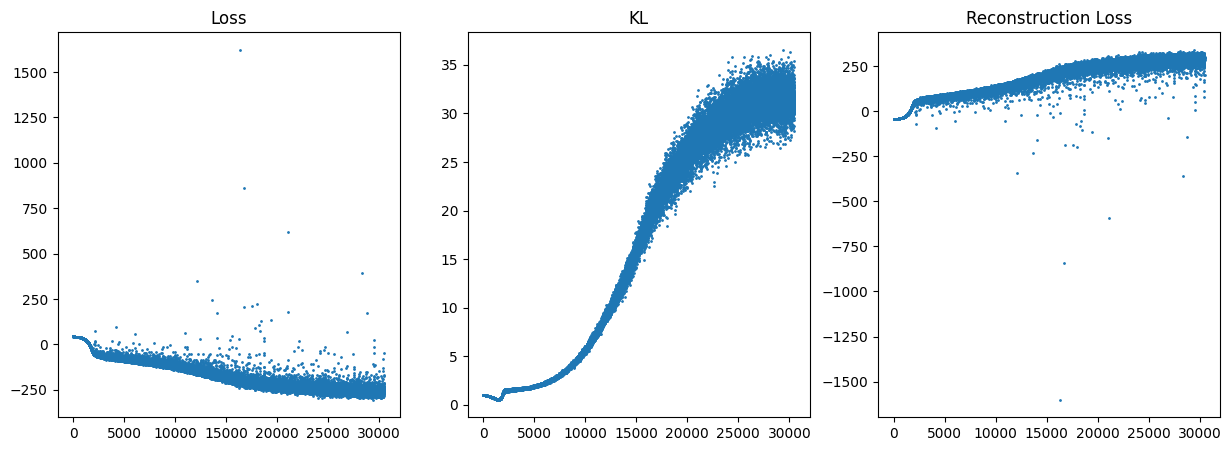

EVALLUATION:
		Plotting ROC curve


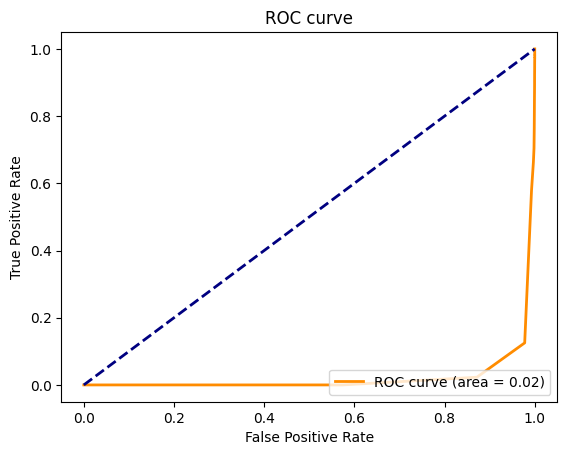

		AUC value = 0.021
		F1 value = 0.078
		AUC PRC value = 0.025


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.006    0.364  0.712                         0.553
1         Probe  0.021    0.025  0.078                         0.040


TOTAL TIME ELAPSED: 3.54 min





RUNNING: FOR ANOMALY CLASS:  DoS
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.FULLY_TABULAR
    	Anomaly class:	StrIntMapping(label='dos', encoded=2)
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	1e-05
    	Length of training dataset 81865
    	Length of test dataset 409953
    
TRAINING:
		Time elapsed: 0.07 min
		Time elapsed: 0.14 min
		Time elapsed: 0.22 min
		Time elapsed: 0.29 min
		Time elapsed: 0.36 min
		Total Training Time: 0.36 min
		Plotting training progress



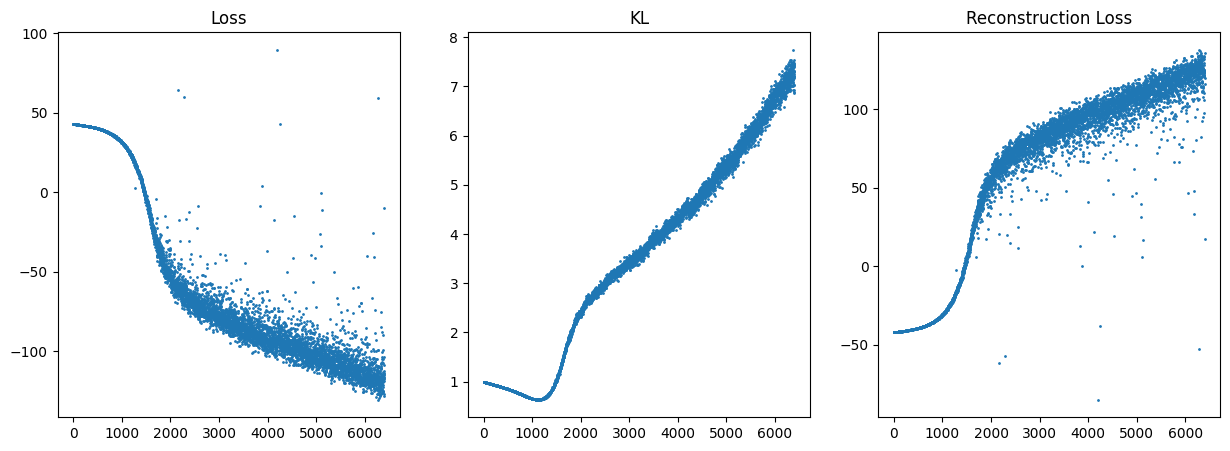

EVALLUATION:
		Plotting ROC curve


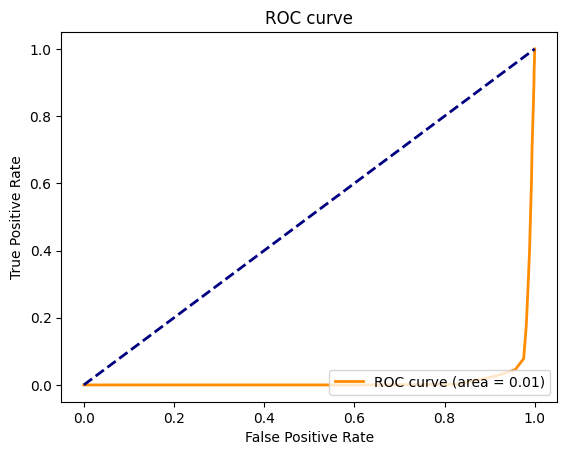

		AUC value = 0.015
		F1 value = 0.974
		AUC PRC value = 0.864


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.006    0.364  0.712                         0.553
1         Probe  0.021    0.025  0.078                         0.040
2           DoS  0.015    0.864  0.974                         0.950


TOTAL TIME ELAPSED: 4.52 min





RUNNING: FOR ANOMALY CLASS:  U2R
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.FULLY_TABULAR
    	Anomaly class:	StrIntMapping(label='u2r', encoded=3)
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	1e-05
    	Length of training dataset 393411
    	Length of test dataset 98407
    
TRAINING:
		Time elapsed: 0.33 min
		Time elapsed: 0.66 min
		Time elapsed: 1.00 min
		Time elapsed: 1.34 min
		Time elapsed: 1.67 min
		Total Training Time: 1.67 min
		Plotting training progress



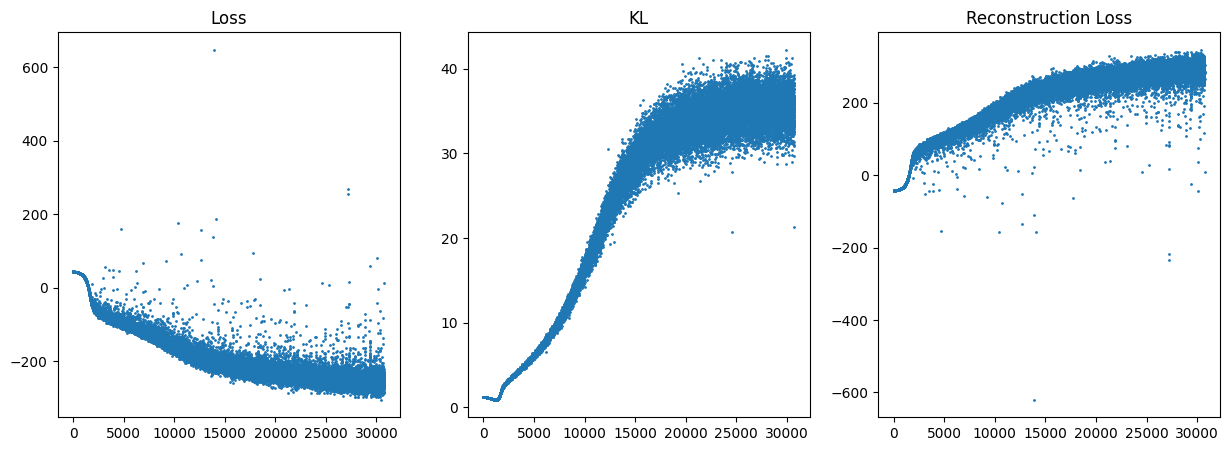

EVALLUATION:
		Plotting ROC curve


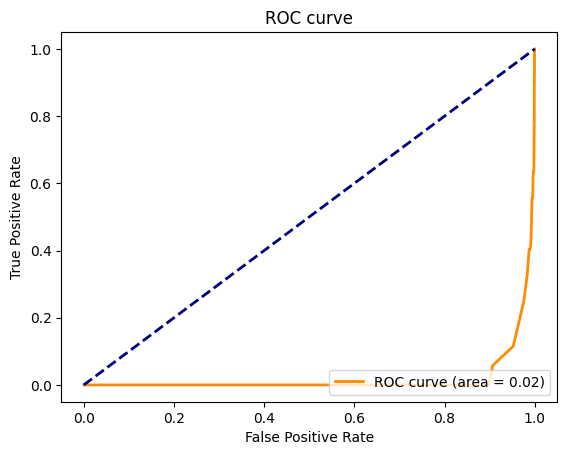

		AUC value = 0.019
		F1 value = 0.001
		AUC PRC value = 0.0


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.006    0.364  0.712                         0.553
1         Probe  0.021    0.025  0.078                         0.040
2           DoS  0.015    0.864  0.974                         0.950
3           U2R  0.019    0.000  0.001                         0.001


TOTAL TIME ELAPSED: 6.37 min





RUNNING: FOR ANOMALY CLASS:  R2L
------------------------------------------------
HYPERPARAMETER:
    	Probabilistic:	True
    	Model:			ModelToTrain.FULLY_TABULAR
    	Anomaly class:	StrIntMapping(label='r2l', encoded=4)
    	Epochs:			5
    	Batch size:		64
    	Learning rate:	1e-05
    	Length of training dataset 392552
    	Length of test dataset 99266
    
TRAINING:
		Time elapsed: 0.33 min
		Time elapsed: 0.66 min
		Time elapsed: 0.99 min
		Time elapsed: 1.33 min
		Time elapsed: 1.66 min
		Total Training Time:

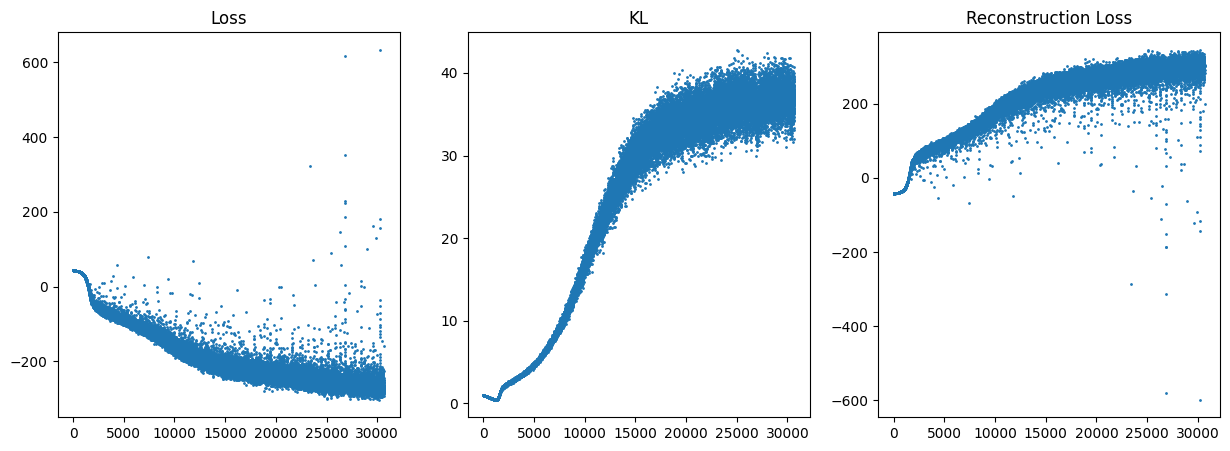

EVALLUATION:
		Plotting ROC curve


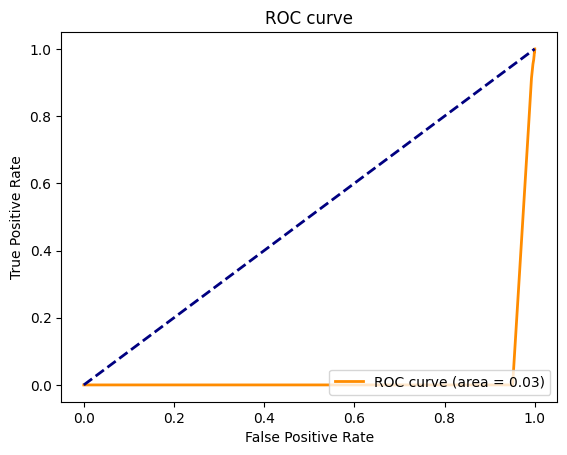

		AUC value = 0.026
		F1 value = 0.022
		AUC PRC value = 0.009


Temporary overview about metrics:

  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.006    0.364  0.712                         0.553
1         Probe  0.021    0.025  0.078                         0.040
2           DoS  0.015    0.864  0.974                         0.950
3           U2R  0.019    0.000  0.001                         0.001
4           R2L  0.026    0.009  0.022                         0.011


TOTAL TIME ELAPSED: 8.19 min





FINAL RESULT
  anomaly_class    auc  auc_prc     f1  anomaly_class_%_in_test_data
0        Normal  0.006    0.364  0.712                         0.553
1         Probe  0.021    0.025  0.078                         0.040
2           DoS  0.015    0.864  0.974                         0.950
3           U2R  0.019    0.000  0.001                         0.001
4           R2L  0.026    0.009  0.022                         0.011


Script finished.


In [25]:
main(
    is_model_probabilistic=True,
    model_to_train=ModelToTrain.FULLY_TABULAR,
    num_epochs=5,
    batch_size=64,
    learning_rate=1e-5,
)